In [1]:
library(tidyverse)
library(here)
library(glue)
library(furrr)
library(cowplot)
library(lemon)
library(here)

devtools::load_all(".")

plan(multiprocess, workers = 30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/archaic-ychr

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: future

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%

Loading ychr


## Plot all trajectories across a grid

In [2]:
read_trajectories <- function(direction, gene_totals, admix_rates, admix_times, reps) {
    future_map_dfr(reps, function(rep) {
    map_dfr(sprintf("%d", gene_totals), function(gene_total) {
    map_dfr(sprintf("%0.2f", admix_rates), function(admix_rate) {
    map_dfr(sprintf("%d", admix_times), function(admix_time) {

        f <- here(glue("data/sim/{direction}/seq{gene_total}_time{admix_time}_rate{admix_rate}_rep{rep}_traj.tsv"))

        read_tsv(f, col_types = "id") %>%
            mutate(gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   admix_rate = as.numeric(admix_rate),
                   rep = rep,
                   time = gen * 25)

    })
    })
    })
    })
}

In [3]:
m2n_traj <- read_trajectories(
    direction = "modern2neand",
    gene_totals = seq(100000, 2000000, 100000),
    admix_rates = 0.05,
    admix_times = seq(150000, 450000, 25000),
    reps = 1:100
)

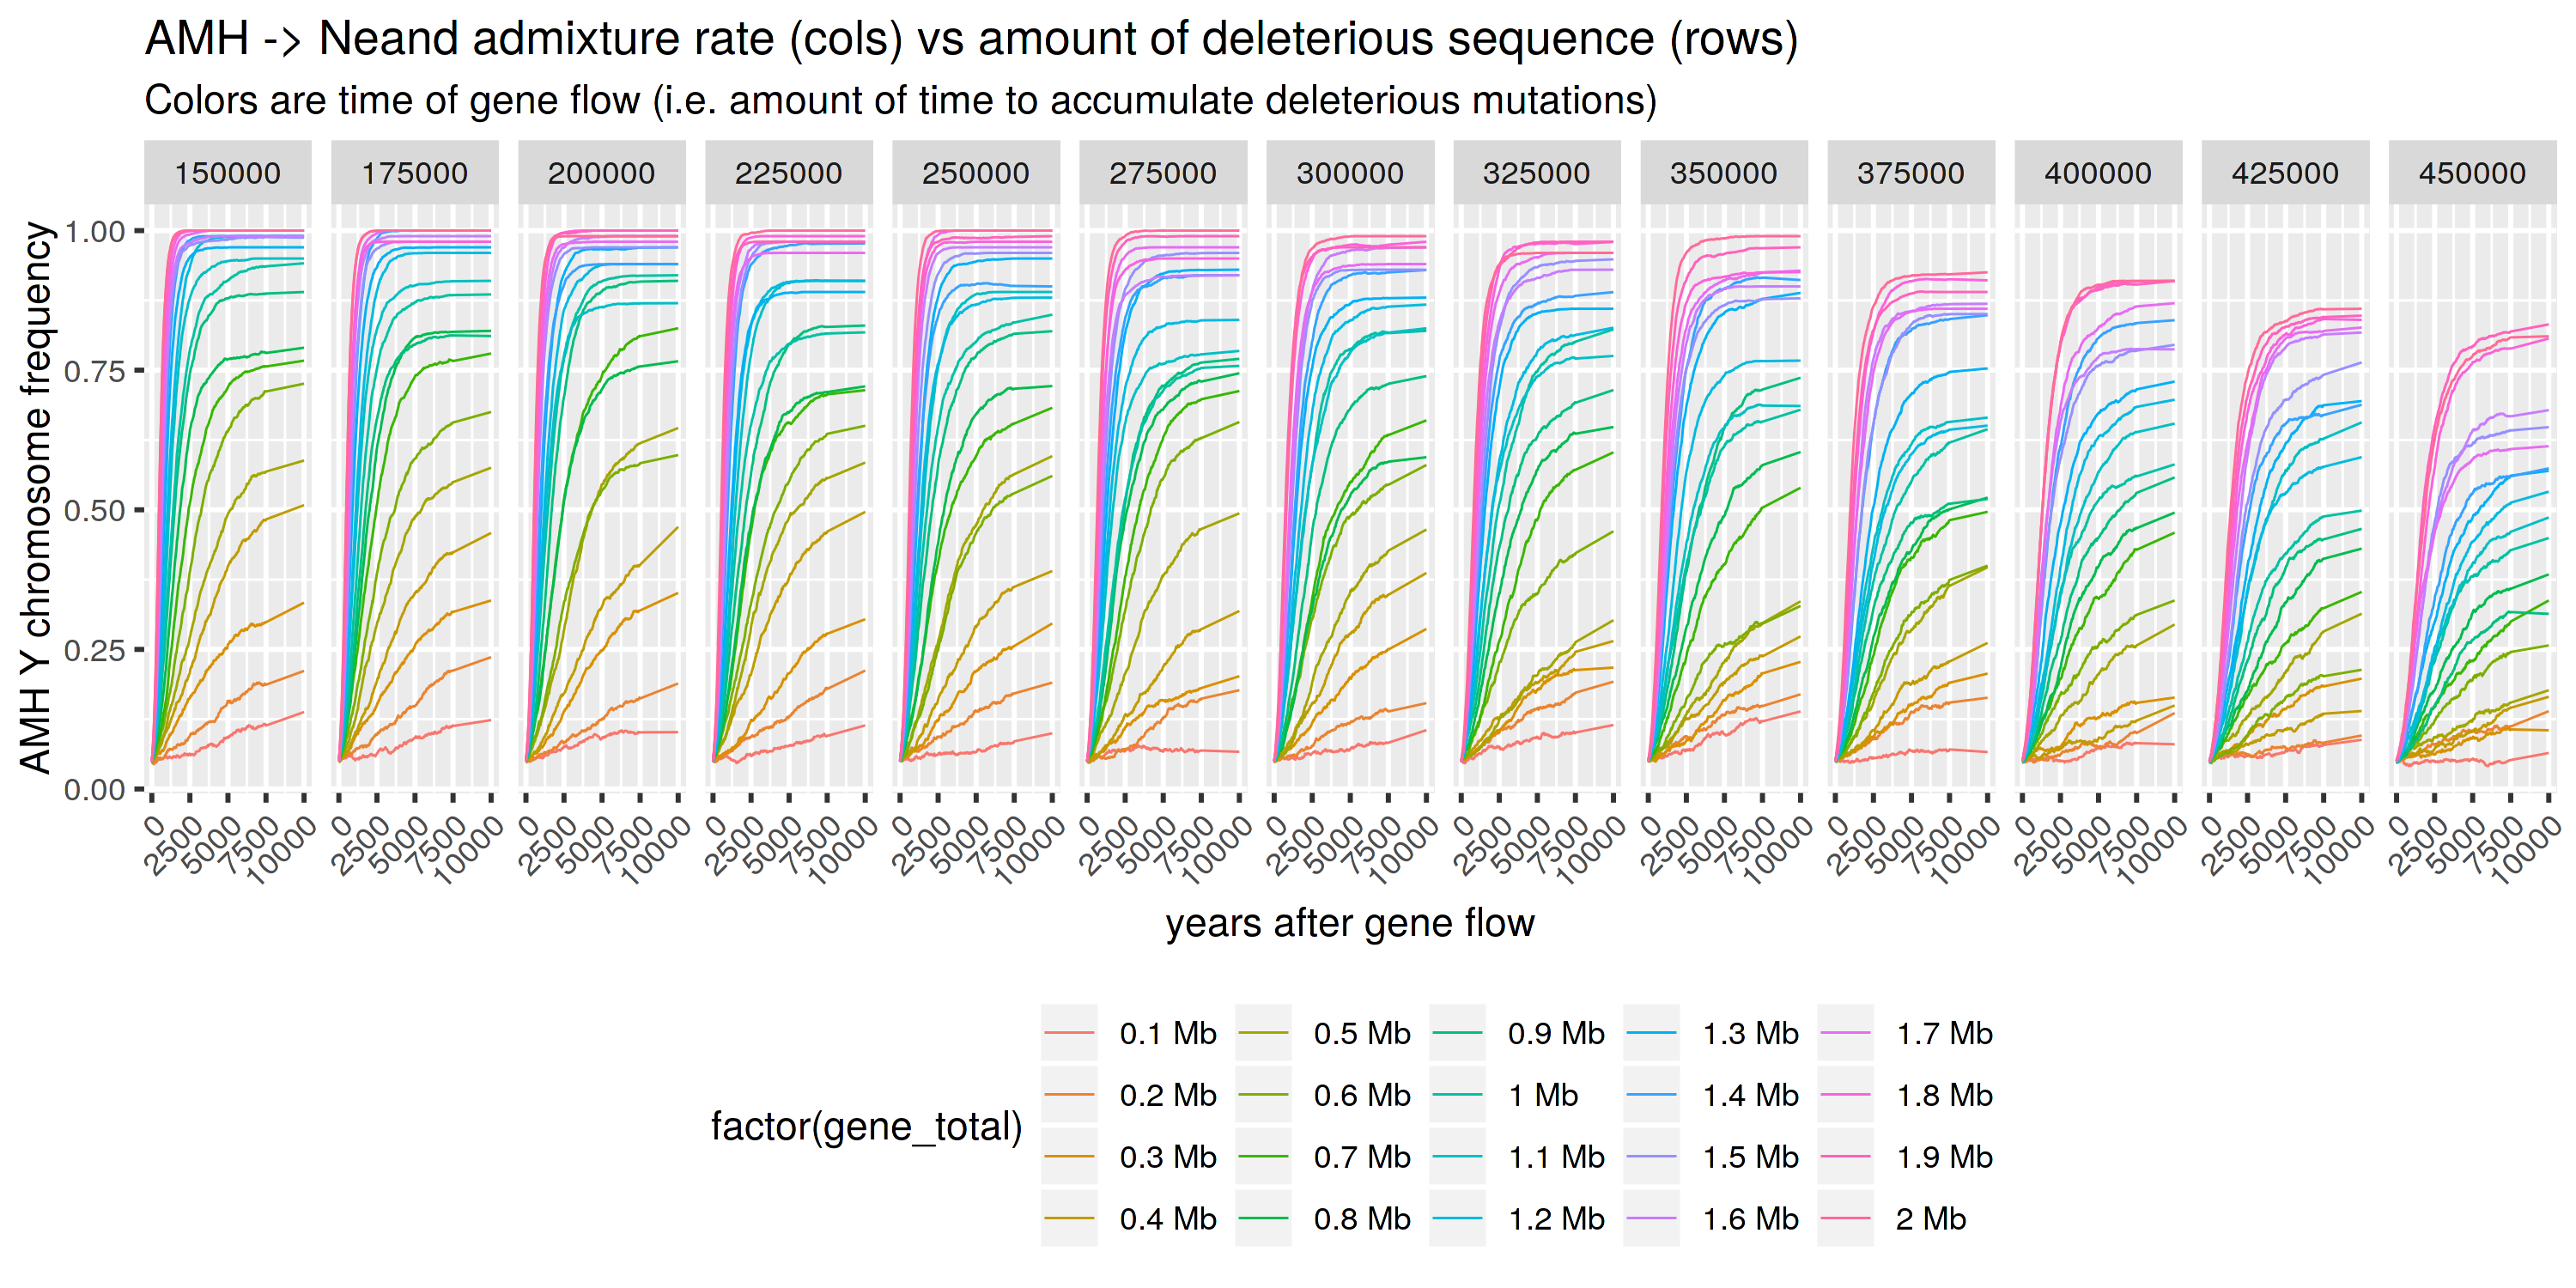

In [4]:
set_dim(10, 5)

m2n_traj %>%
filter(gen < 500) %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(gen, time, gene_total, admix_time, admix_rate) %>%
summarise(ancestry = mean(ancestry)) %>%
ggplot(aes(time, ancestry, color = factor(gene_total))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("AMH Y chromosome frequency") +
    facet_grid(~ admix_time) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

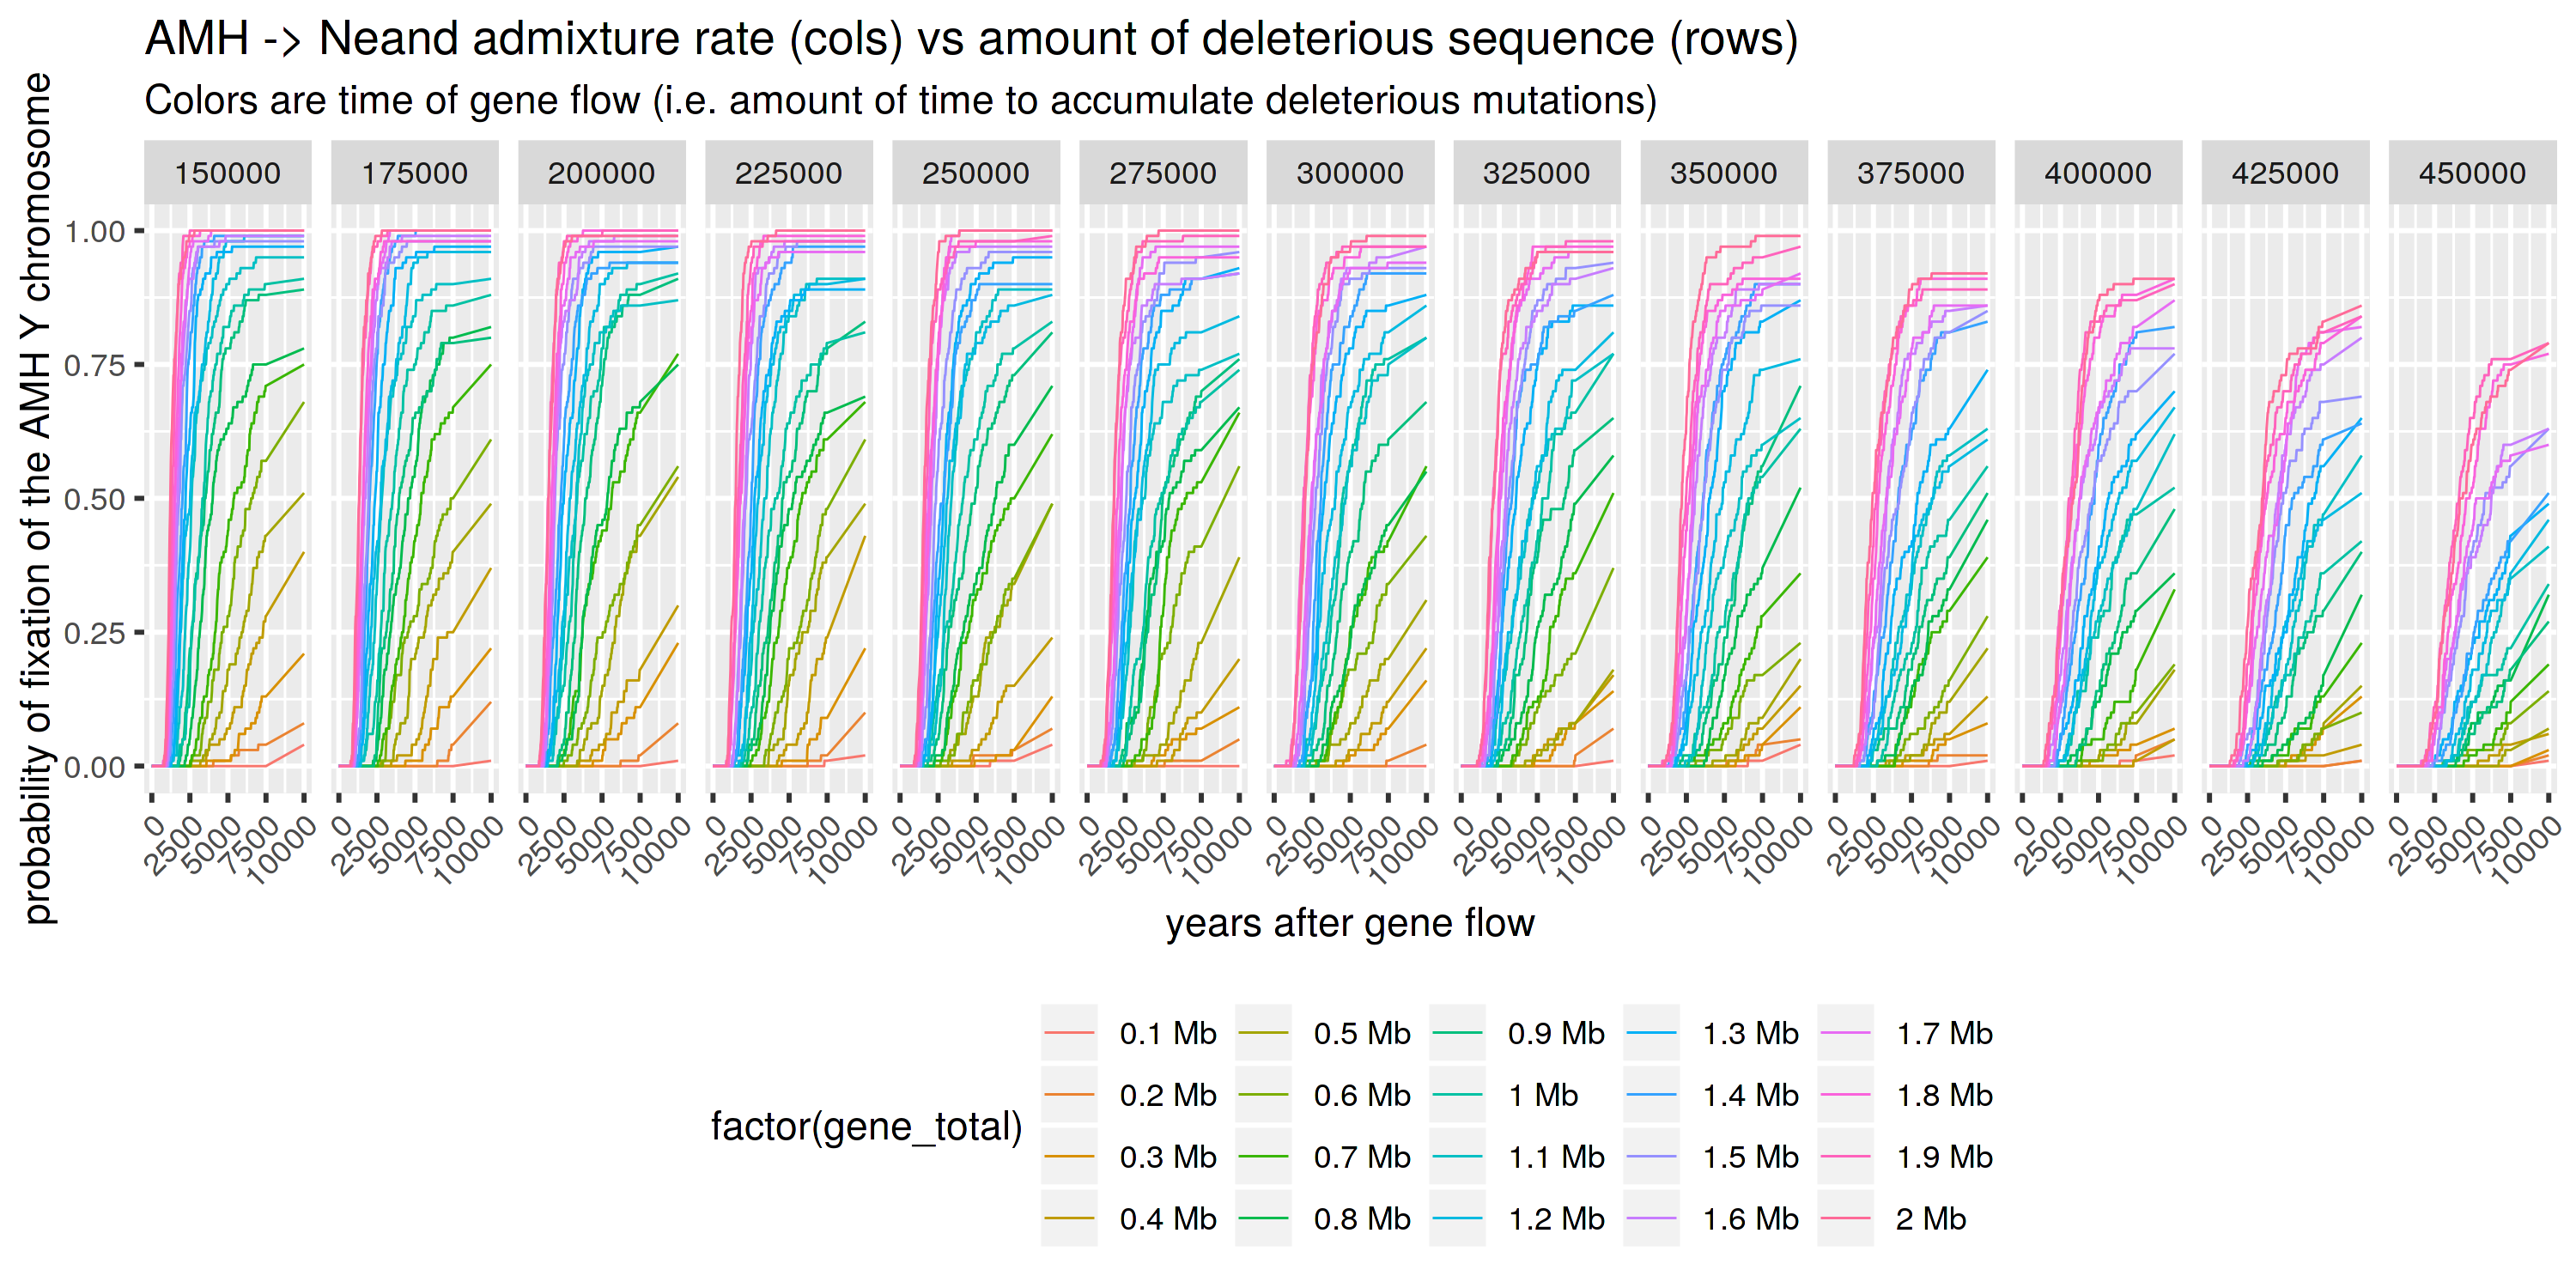

In [5]:
set_dim(10, 5)

m2n_traj %>%
filter(gen < 500) %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(gen, time, gene_total, admix_time, admix_rate) %>%
summarise(ancestry = mean(ancestry == 1)) %>%
ggplot(aes(time, ancestry, color = factor(gene_total))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("probability of fixation of the AMH Y chromosome") +
    facet_grid(~ admix_time) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

## Assign fitness values to trajectories

In [6]:
read_fitness <- function(direction, gene_totals, admix_rates, admix_times, reps) {
    future_map_dfr(reps, function(rep) {
    map_dfr(sprintf("%d", gene_totals), function(gene_total) {
    map_dfr(sprintf("%0.2f", admix_rates), function(admix_rate) {
    map_dfr(sprintf("%d", admix_times), function(admix_time) {

        f <- here(glue("data/sim/{direction}/seq{gene_total}_time{admix_time}_rate{admix_rate}_rep{rep}_pop.txt.gz"))

        read_slim(f) %>%
            calculate_fitness %>%
            mutate(gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   admix_rate = as.numeric(admix_rate),
                   rep = rep)

    })
    })
    })
    }) %>%
    mutate(pop = case_when(pop == "p1" ~ "AMH", pop == "p2" ~ "Neanderthals"))
}

In [7]:
fitness <- read_fitness(
    direction = "modern2neand",
    gene_totals = seq(100000, 2000000, 100000),
    admix_rates = 0.05,
    admix_times = seq(150000, 450000, 25000),
    reps = 1:100
)

In [8]:
head(fitness)

genome_id pop S            fitness   gene_total admix_time admix_rate rep
1 p1:10001  AMH 0.0006488237 0.9993514 100000     150000     0.05       1  
2 p1:10003  AMH 0.0012242058 0.9987765 100000     150000     0.05       1  
3 p1:10005  AMH 0.0007664712 0.9992338 100000     150000     0.05       1  
4 p1:10007  AMH 0.0006488237 0.9993514 100000     150000     0.05       1  
5 p1:10009  AMH 0.0001974642 0.9998026 100000     150000     0.05       1  
6 p1:10011  AMH 0.0012989588 0.9987019 100000     150000     0.05       1

Calculate average fitness for each genome across all replicates:

In [9]:
mean_fitness <- fitness %>%
    group_by(genome_id, pop, gene_total, admix_time, admix_rate) %>%
    summarise(fitness = mean(fitness))

In [10]:
head(mean_fitness)

genome_id pop gene_total admix_time admix_rate fitness  
1 p1:10001  AMH 100000     150000     0.05       0.9981442
2 p1:10001  AMH 100000     175000     0.05       0.9986484
3 p1:10001  AMH 100000     200000     0.05       0.9988816
4 p1:10001  AMH 100000     225000     0.05       0.9987985
5 p1:10001  AMH 100000     250000     0.05       0.9986730
6 p1:10001  AMH 100000     275000     0.05       0.9988236

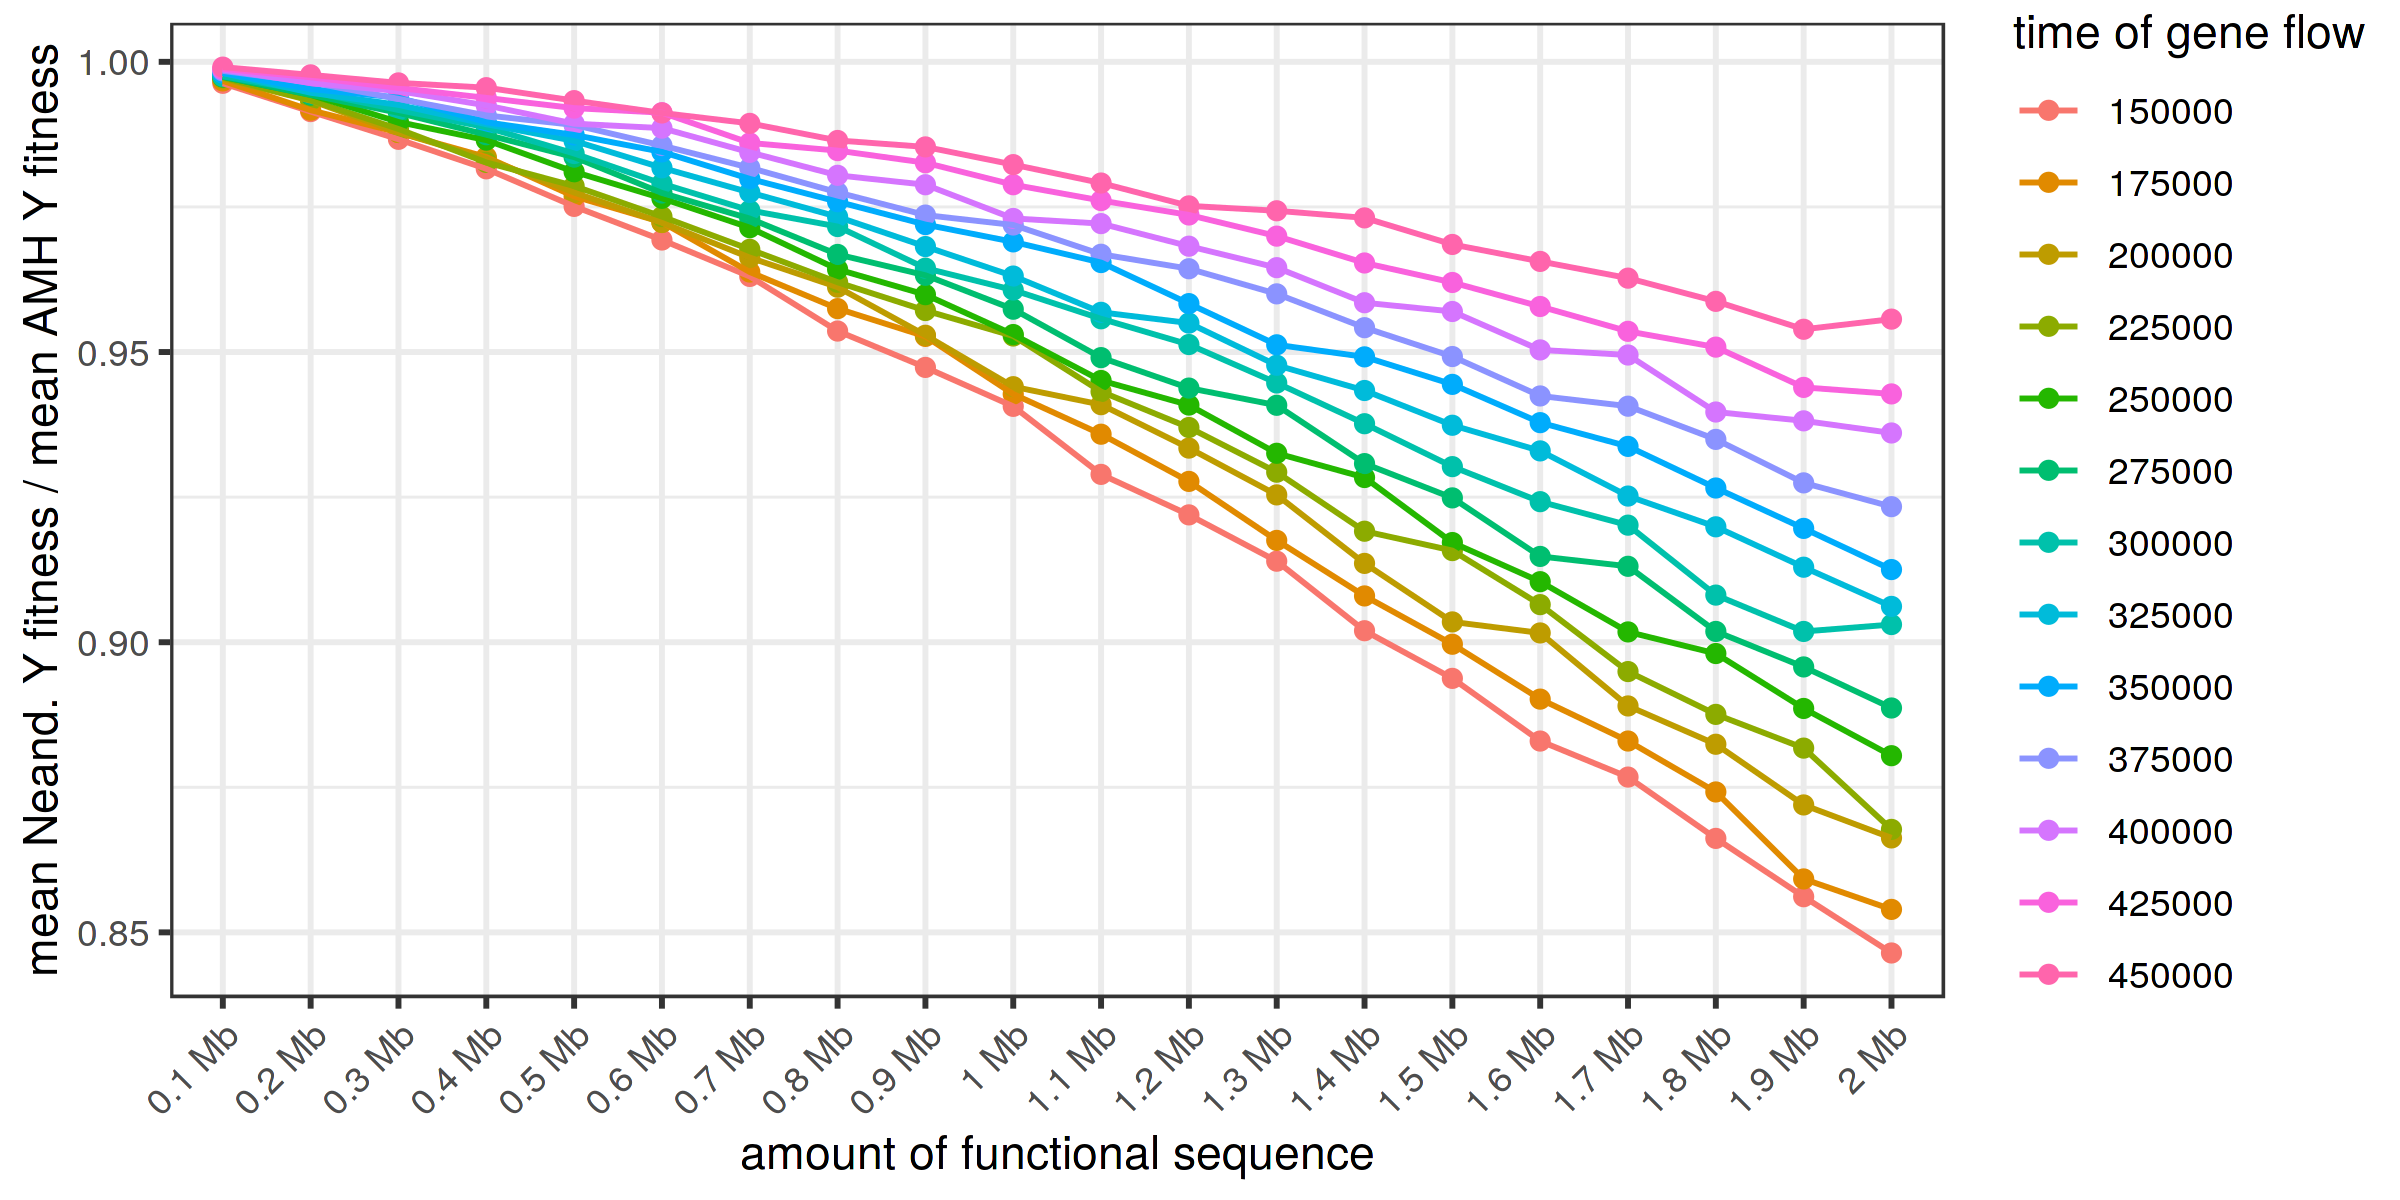

In [11]:
set_dim(8, 4)

mean_fitness %>%
ungroup %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(pop, gene_total, admix_time, admix_rate) %>%
summarise(fitness = mean(fitness)) %>%
spread(pop, fitness) %>%
mutate(ratio = Neanderthals / AMH) %>%
ggplot(aes(factor(gene_total), ratio, color = factor(admix_time), group = factor(admix_time))) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    labs(color = "time of gene flow",
         y = "mean Neand. Y fitness / mean AMH Y fitness",
         x = "amount of functional sequence")

Annotate each replicate trajectory with the value of Neanderthal and AMH loads prior to the gene flow event:

In [12]:
traj_fitness <- fitness %>%
    group_by(pop, rep, gene_total, admix_time, admix_rate) %>%
    summarise_if(is.numeric, mean) %>%
    select(-S) %>%
    spread(pop, fitness) %>%
    mutate(ratio = 1 - Neanderthals / AMH) %>%
    inner_join(m2n_traj) %>% mutate(time = gen * 25)

Joining, by = c("rep", "gene_total", "admix_time", "admix_rate")


In [13]:
head(traj_fitness)

rep gene_total admix_time admix_rate AMH       Neanderthals ratio       gen
1 1   100000     150000     0.05       0.9978176 0.994537     0.003287741 0  
2 1   100000     150000     0.05       0.9978176 0.994537     0.003287741 1  
3 1   100000     150000     0.05       0.9978176 0.994537     0.003287741 2  
4 1   100000     150000     0.05       0.9978176 0.994537     0.003287741 3  
5 1   100000     150000     0.05       0.9978176 0.994537     0.003287741 4  
6 1   100000     150000     0.05       0.9978176 0.994537     0.003287741 5  
  ancestry time
1 0.070      0 
2 0.054     25 
3 0.050     50 
4 0.052     75 
5 0.058    100 
6 0.052    125

Assign trajectories to bins based on the relative Neand/AMH fitness:

In [14]:
mean_traj_fitness <- traj_fitness %>%
    group_by(gen, time, gene_total, admix_time, admix_rate) %>%
    summarise(ancestry = mean(ancestry),
              ratio = mean(ratio))

In [15]:
min(mean_traj_fitness$ratio)

[1] 0.0008969507

In [16]:
max(mean_traj_fitness$ratio)

[1] 0.1534937

In [17]:
(boundaries <- c(0.0, seq(0.005, 0.16, 0.01)))

[1] 0.000 0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105
[13] 0.115 0.125 0.135 0.145 0.155

In [18]:
mean_traj_fitness <- mean_traj_fitness %>% mutate(fitness_bin = cut(ratio, boundaries))

In [19]:
mean_traj_fitness$fitness_bin %>% table

.
    (0,0.005] (0.005,0.015] (0.015,0.025] (0.025,0.035] (0.035,0.045] 
         7098         13858         10478          9802          8788 
(0.045,0.055] (0.055,0.065] (0.065,0.075] (0.075,0.085] (0.085,0.095] 
         6760          8112          4732          3718          3718 
(0.095,0.105] (0.105,0.115] (0.115,0.125] (0.125,0.135] (0.135,0.145] 
         3380          2366          2028          1690           676 
(0.145,0.155] 
          676 

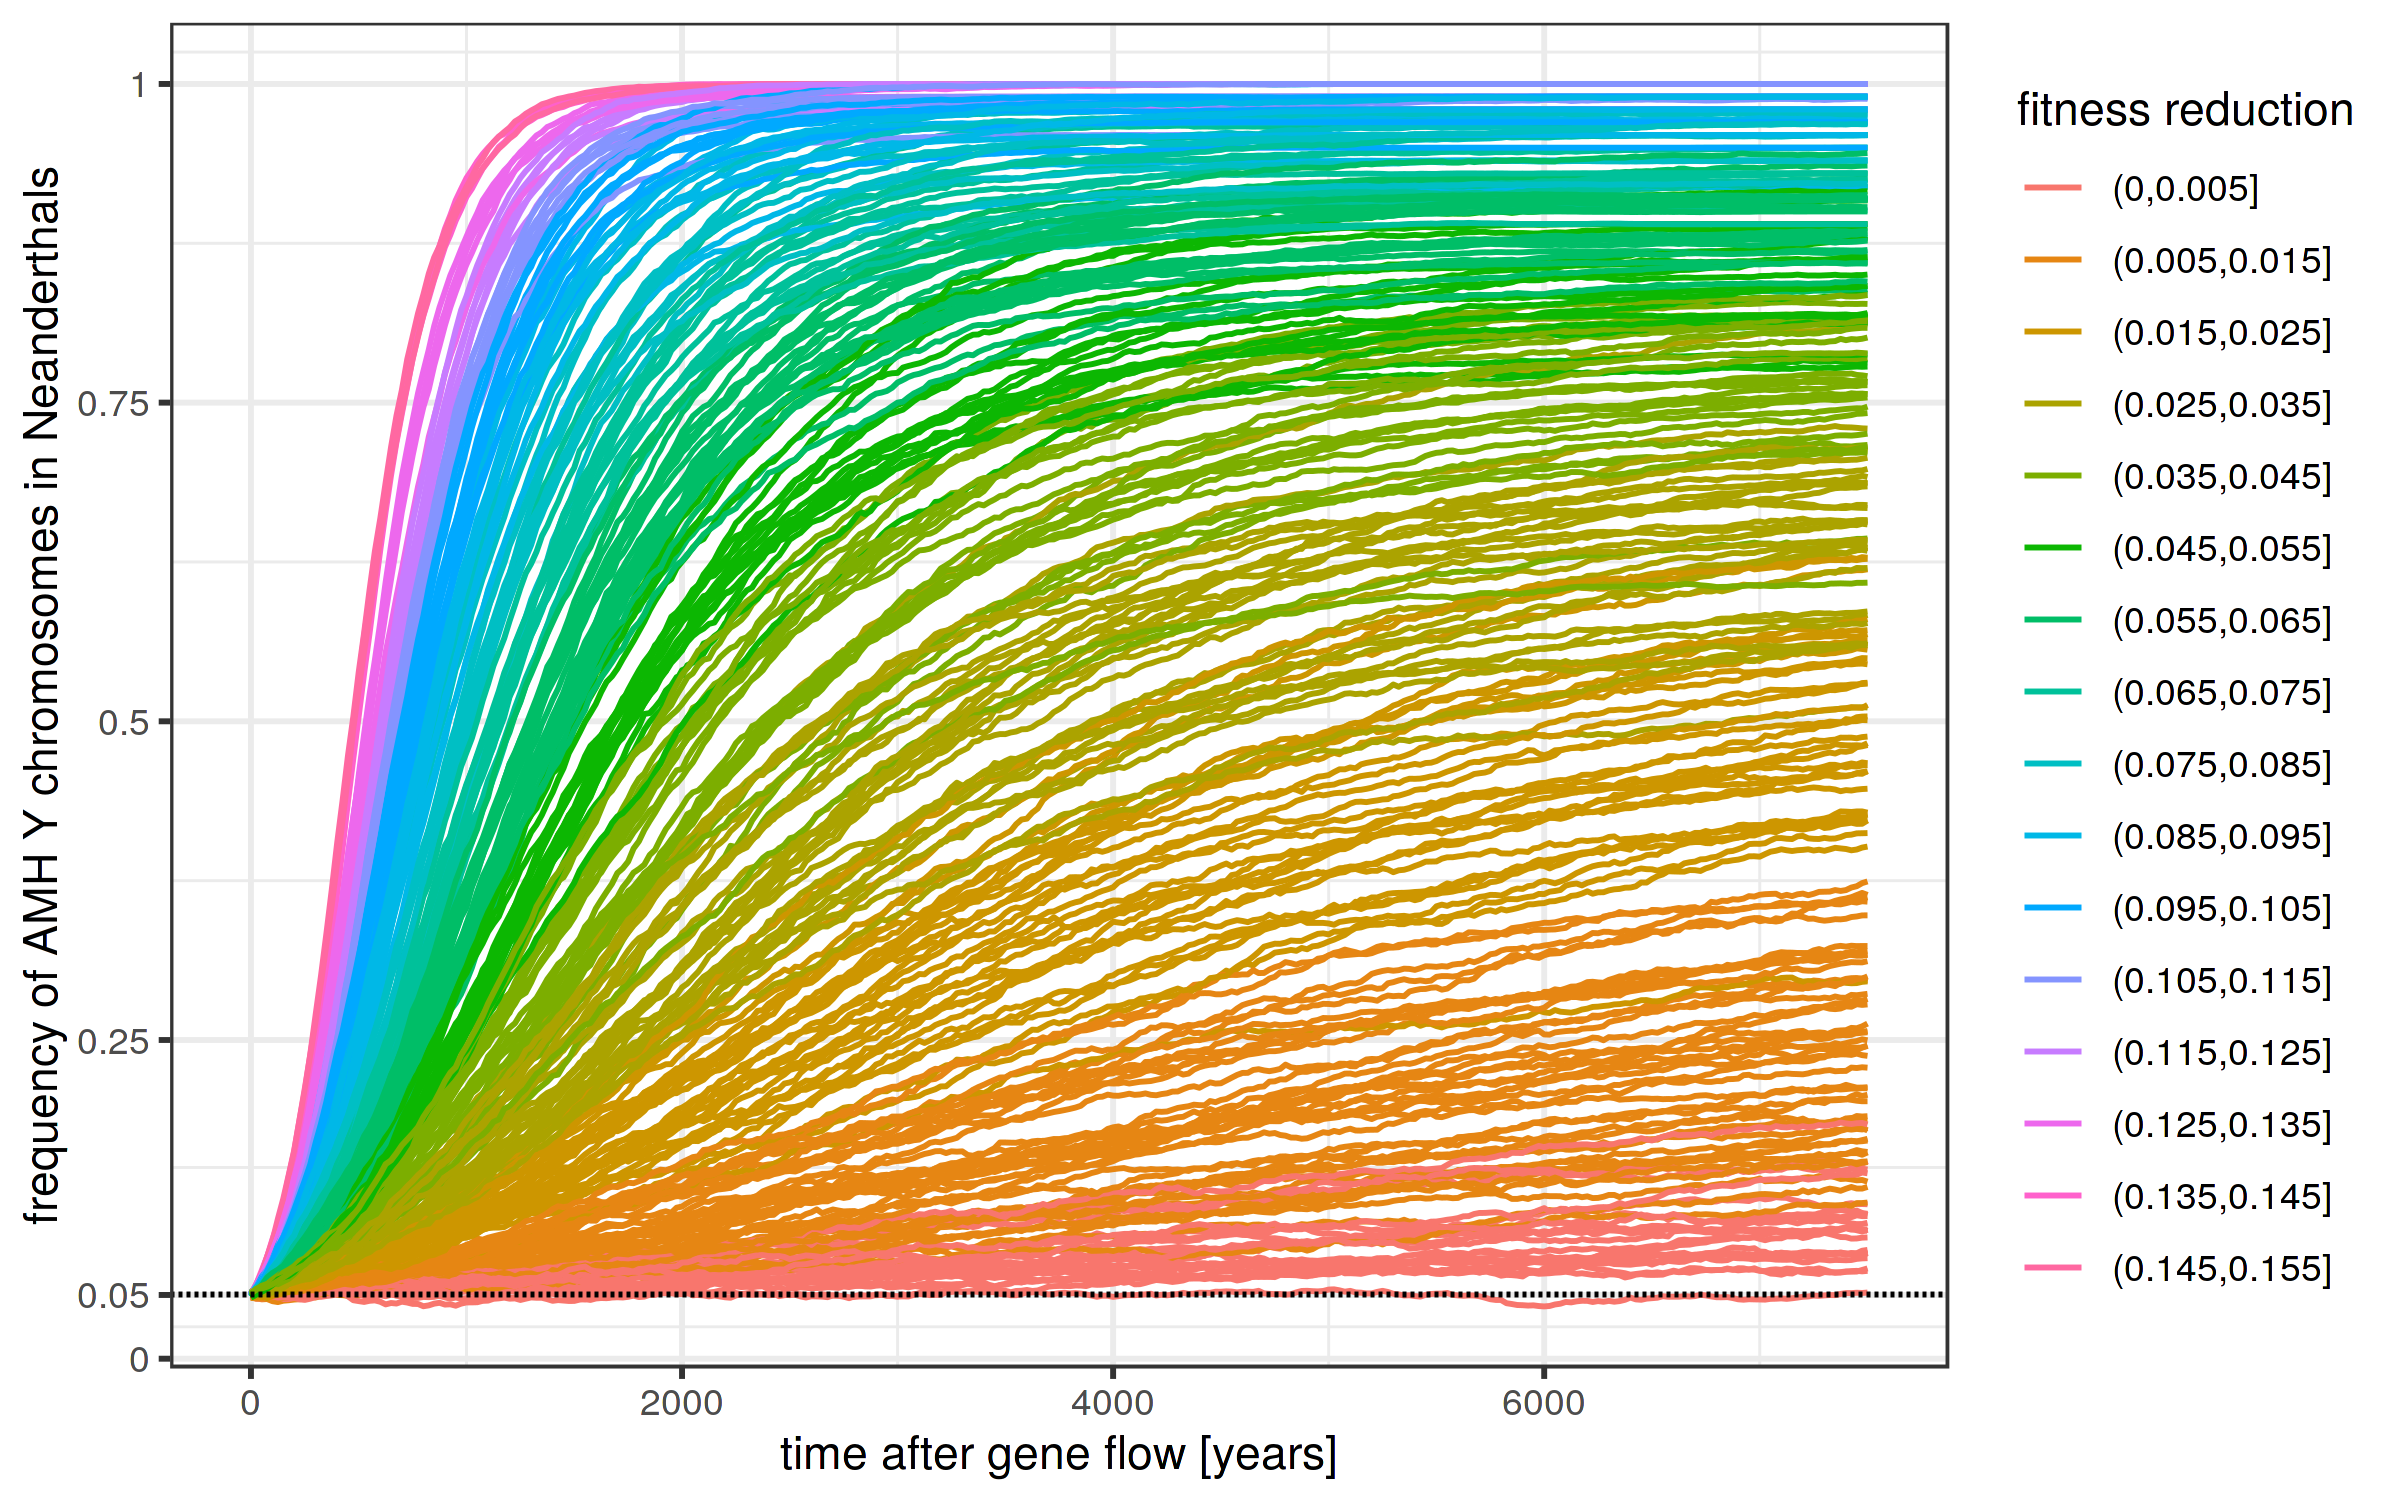

In [20]:
set_dim(8, 5)

mean_traj_fitness %>%
filter(gen < 400) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    geom_hline(yintercept = 0.05, linetype = 2) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "frequency of AMH Y chromosomes in Neanderthals",
         x = "time after gene flow [years]") +
    scale_y_continuous(breaks = c(0, 0.05, 0.25, 0.5, 0.75, 1), labels= c(0, 0.05, 0.25, 0.5, 0.75, 1))

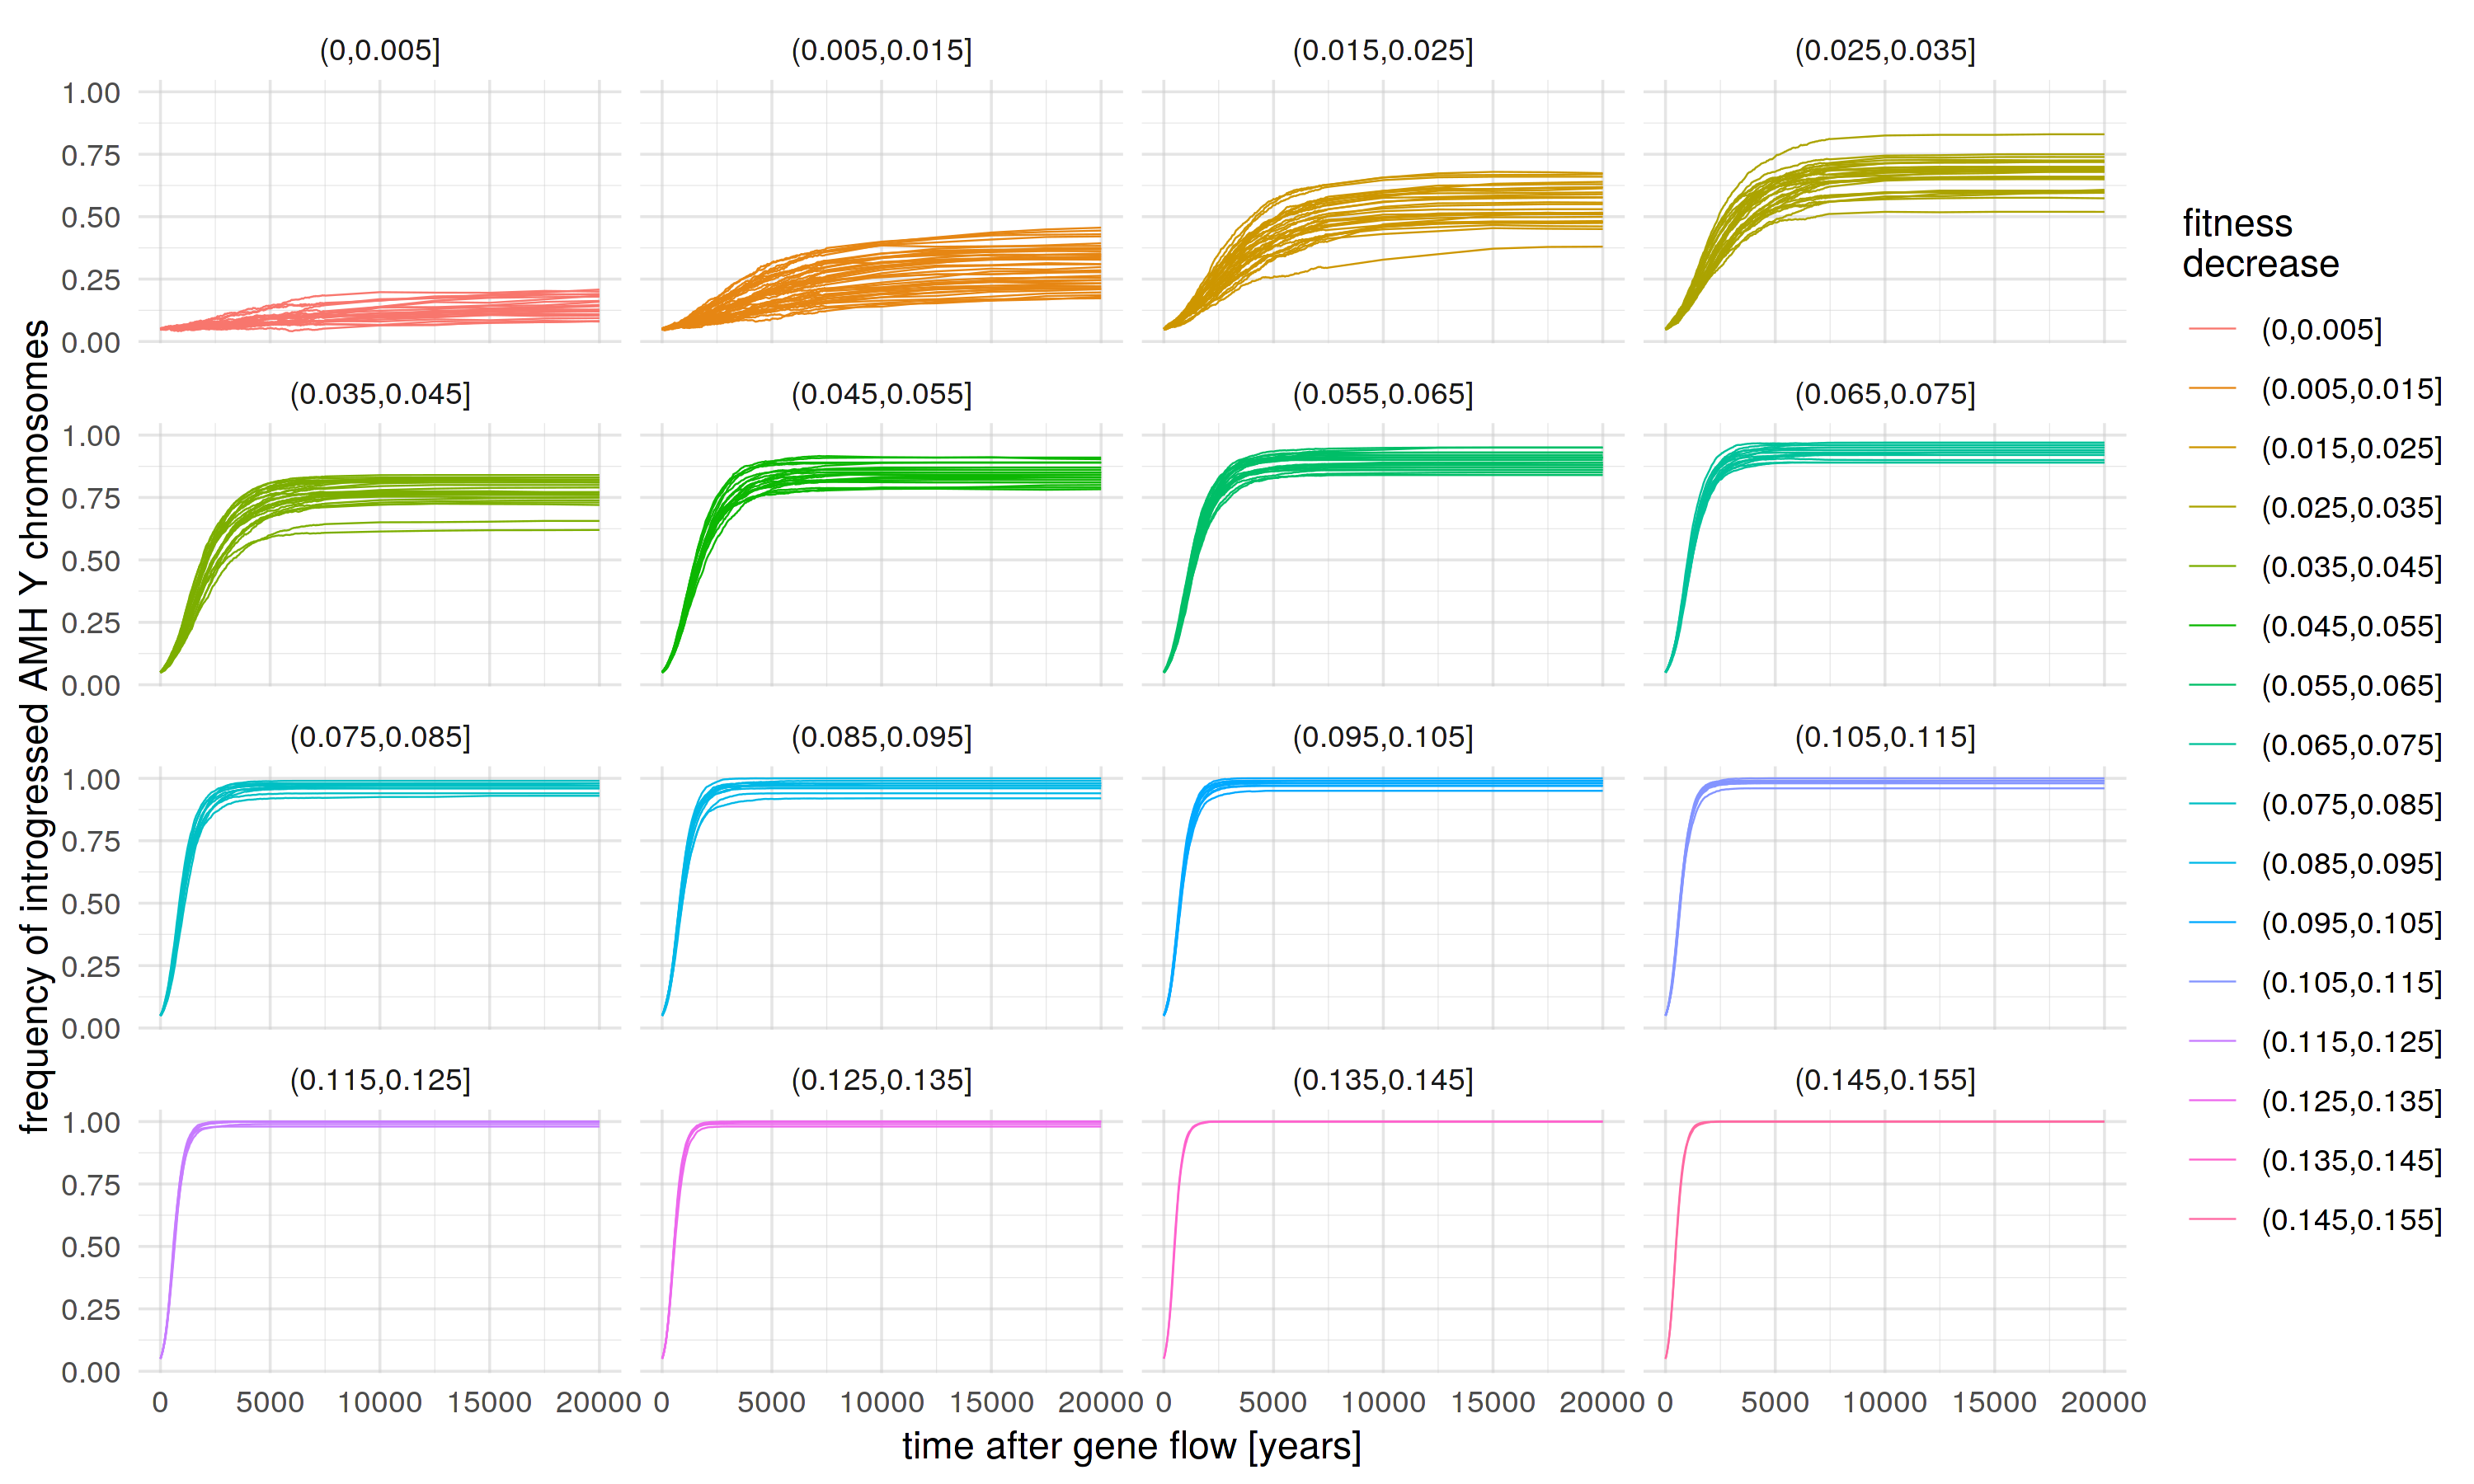

In [21]:
set_dim(10, 6)

mean_traj_fitness %>%
filter(time <= 20000) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time)), size = 1/5) +
    facet_wrap(~ fitness_bin) +
    theme_minimal() +
    background_grid(
        major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
        color.major = rgb(0.8, 0.8, 0.8, alpha = 0.5),
        color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.5)
    ) +
    labs(color = "fitness\ndecrease",
         y = "frequency of introgressed AMH Y chromosomes",
         x = "time after gene flow [years]")

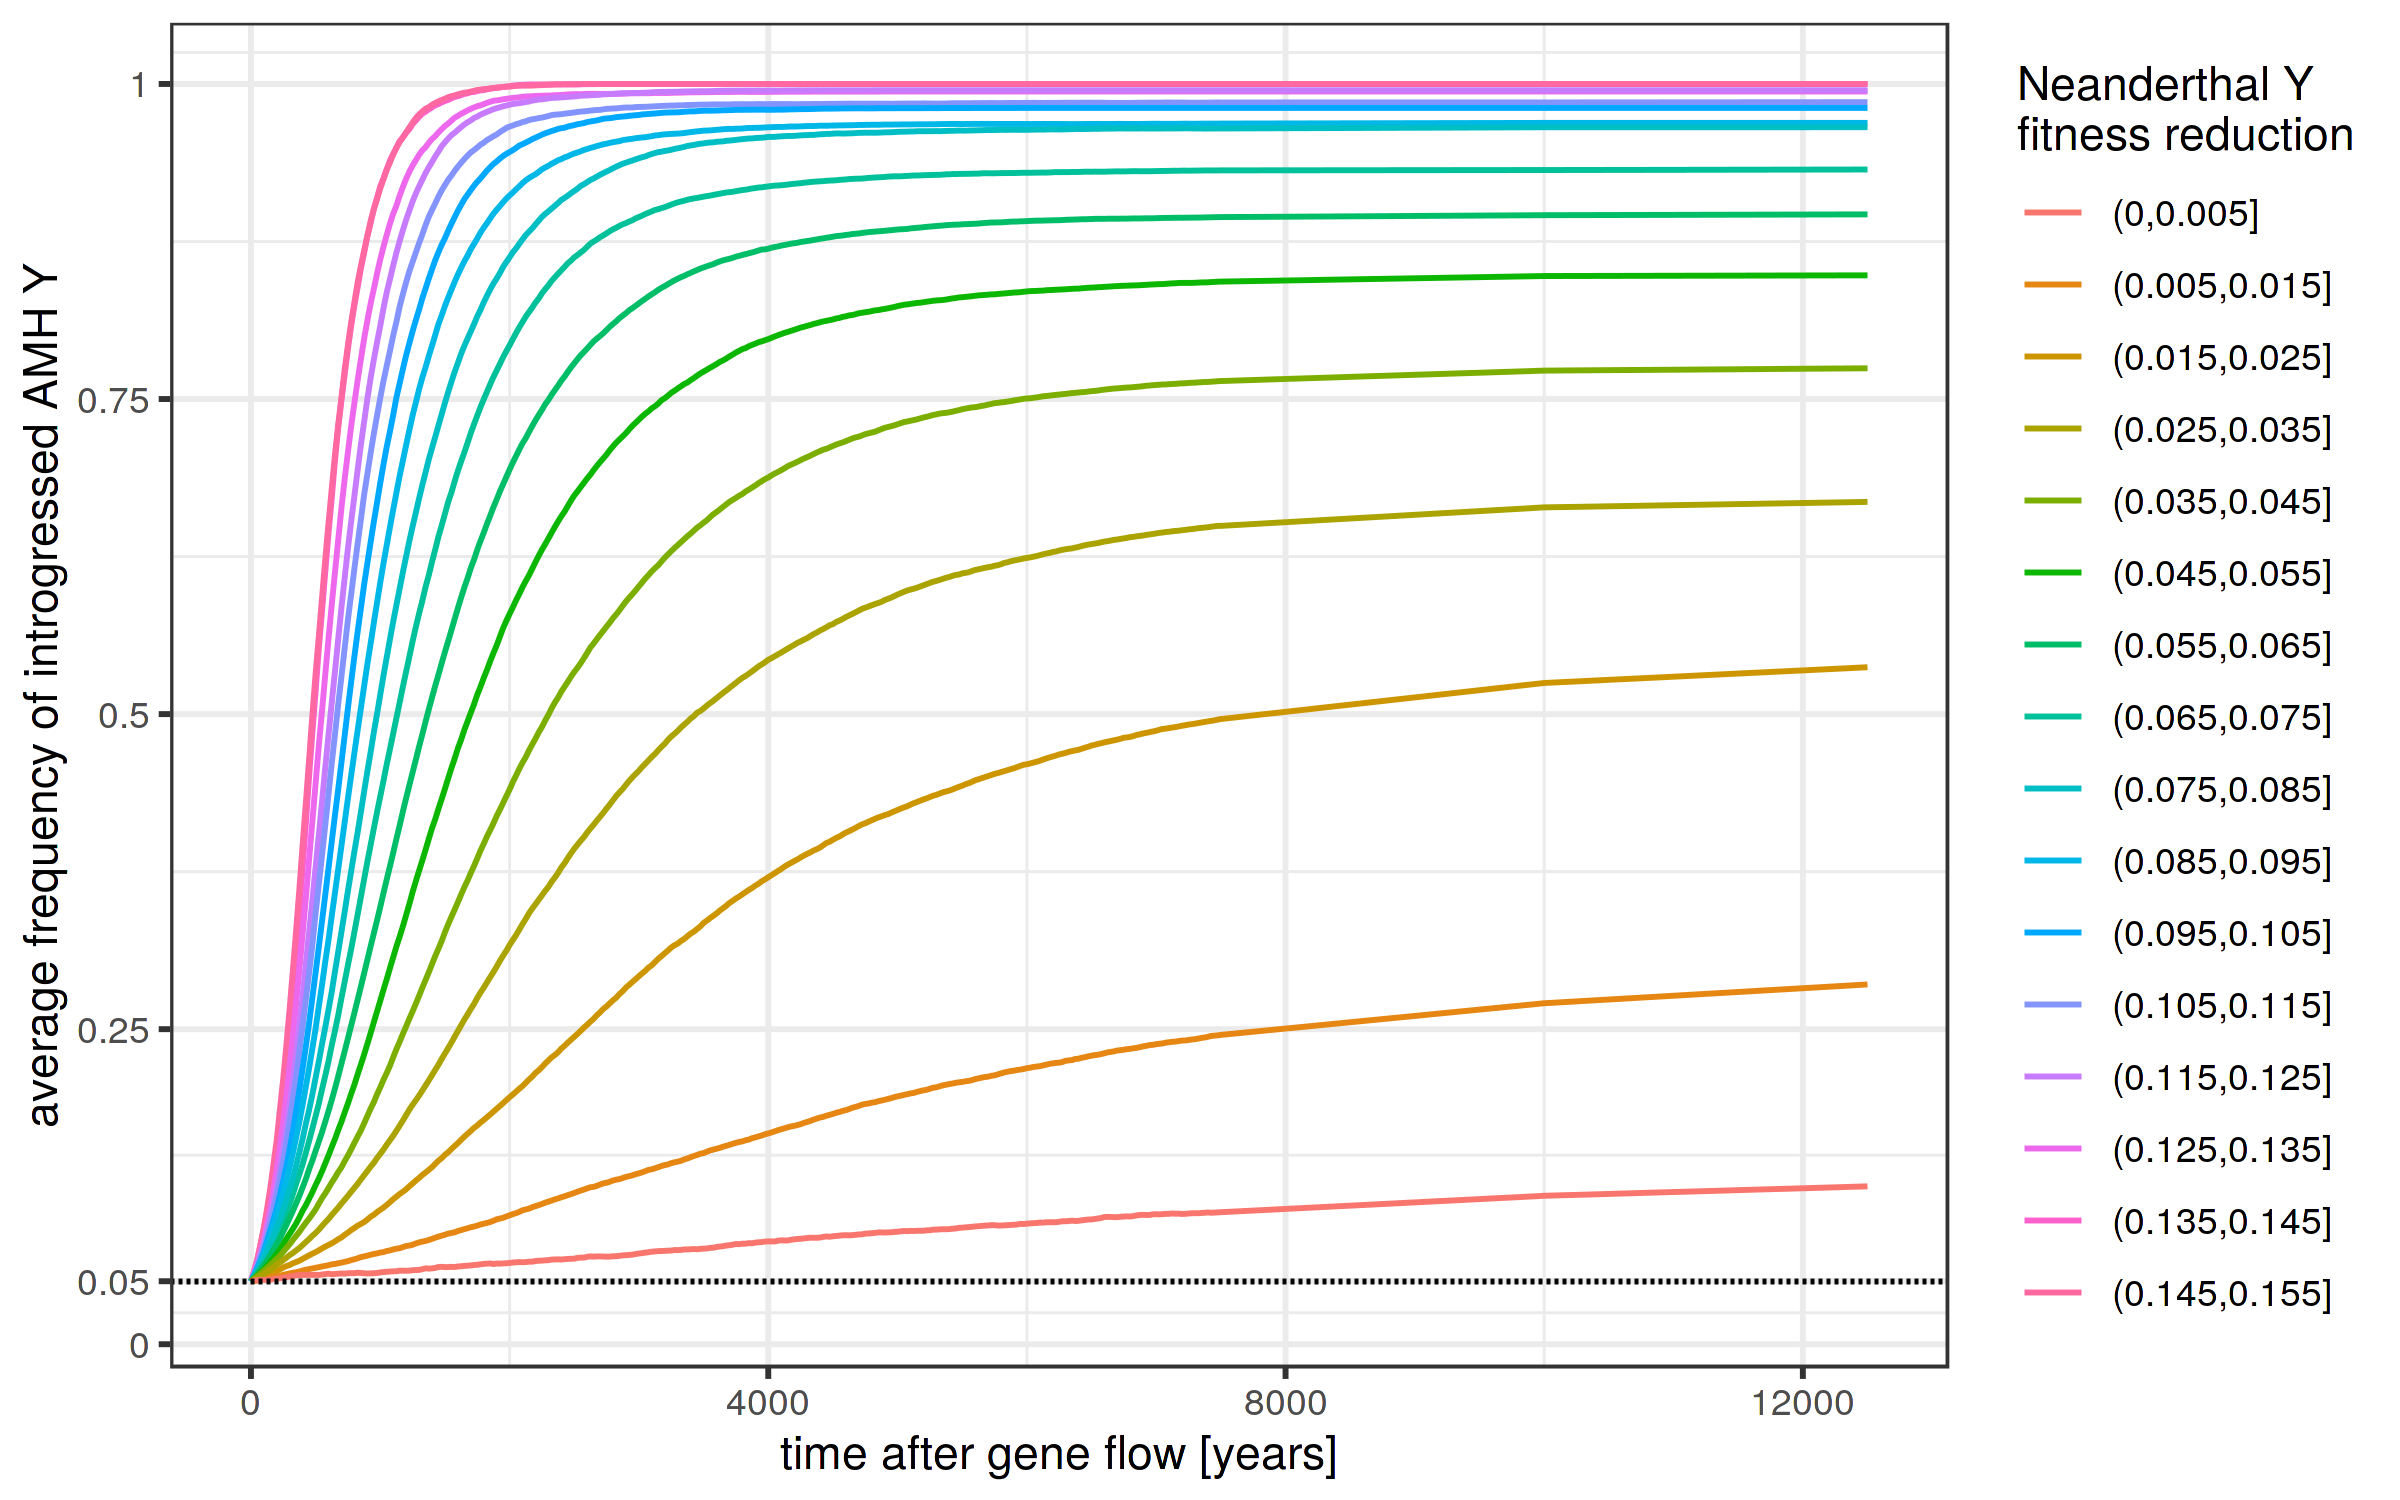

In [22]:
set_dim(8, 5)

mean_traj_fitness %>%
group_by(fitness_bin, gen, time) %>%
summarise_if(is.numeric, mean) %>%
filter(gen < 600) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    geom_hline(yintercept = 0.05, linetype = 2) +
    theme_bw() +
    labs(color = "Neanderthal Y\nfitness reduction",
         y = "average frequency of introgressed AMH Y",
         x = "time after gene flow [years]") +
    coord_cartesian(y = c(0.03, 1)) +
    scale_y_continuous(breaks = c(0, 0.05, 0.25, 0.5, 0.75, 1), labels = c(0, 0.05, 0.25, 0.5, 0.75, 1))

In [23]:
prob_traj_fitness <- traj_fitness %>%
    group_by(gen, time, gene_total, admix_time, admix_rate) %>%
    summarise(prob_fix = mean(ancestry == 1),
              ratio = mean(ratio))

In [24]:
prob_traj_fitness <- prob_traj_fitness %>% mutate(fitness_bin = cut(ratio, boundaries))

In [25]:
prob_traj_fitness %>% head

gen time gene_total admix_time admix_rate prob_fix ratio       fitness_bin
1 0   0    100000     150000     0.05       0        0.003698595 (0,0.005]  
2 0   0    100000     175000     0.05       0        0.003288417 (0,0.005]  
3 0   0    100000     200000     0.05       0        0.002932130 (0,0.005]  
4 0   0    100000     225000     0.05       0        0.002722413 (0,0.005]  
5 0   0    100000     250000     0.05       0        0.002590202 (0,0.005]  
6 0   0    100000     275000     0.05       0        0.002563436 (0,0.005]

In [26]:
saveRDS(prob_traj_fitness, "/mnt/expressions/mp/archaic-ychr/data/rds/prob_traj_fitness.rds")

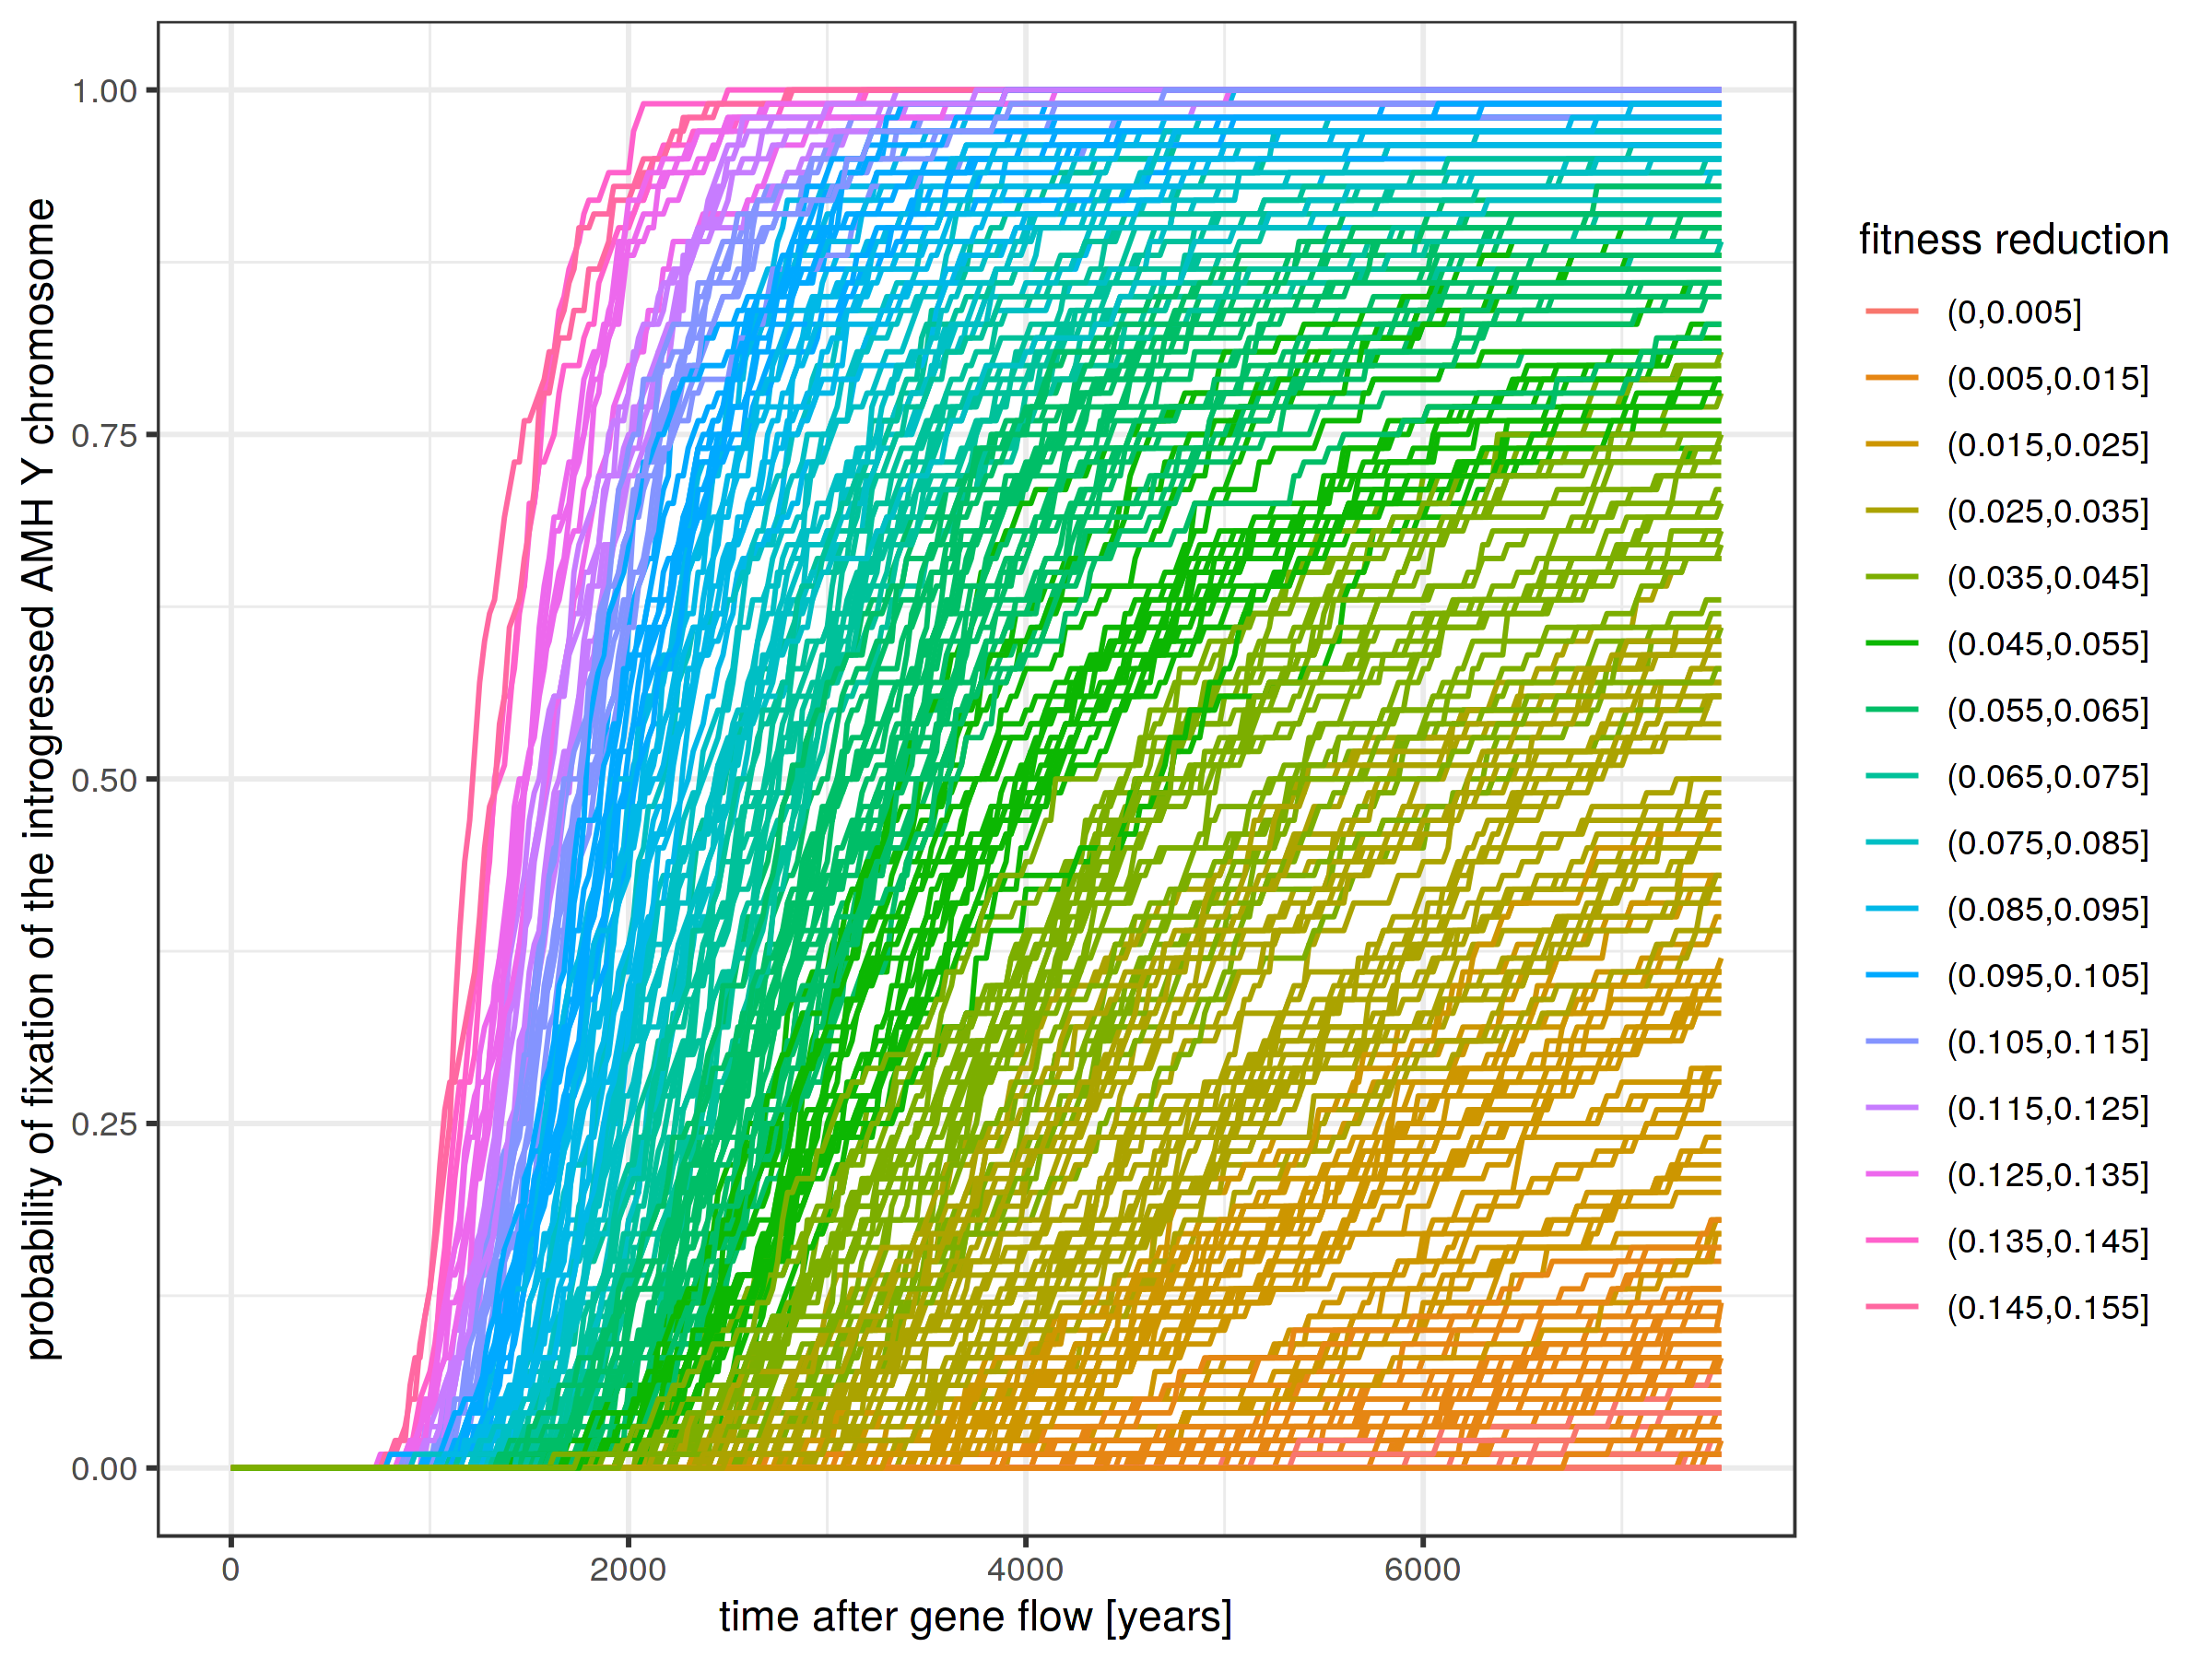

In [27]:
set_dim(8, 6)

prob_traj_fitness %>%
filter(gen < 400) %>%
ggplot(aes(time, prob_fix, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of the introgressed AMH Y chromosome",
         x = "time after gene flow [years]")

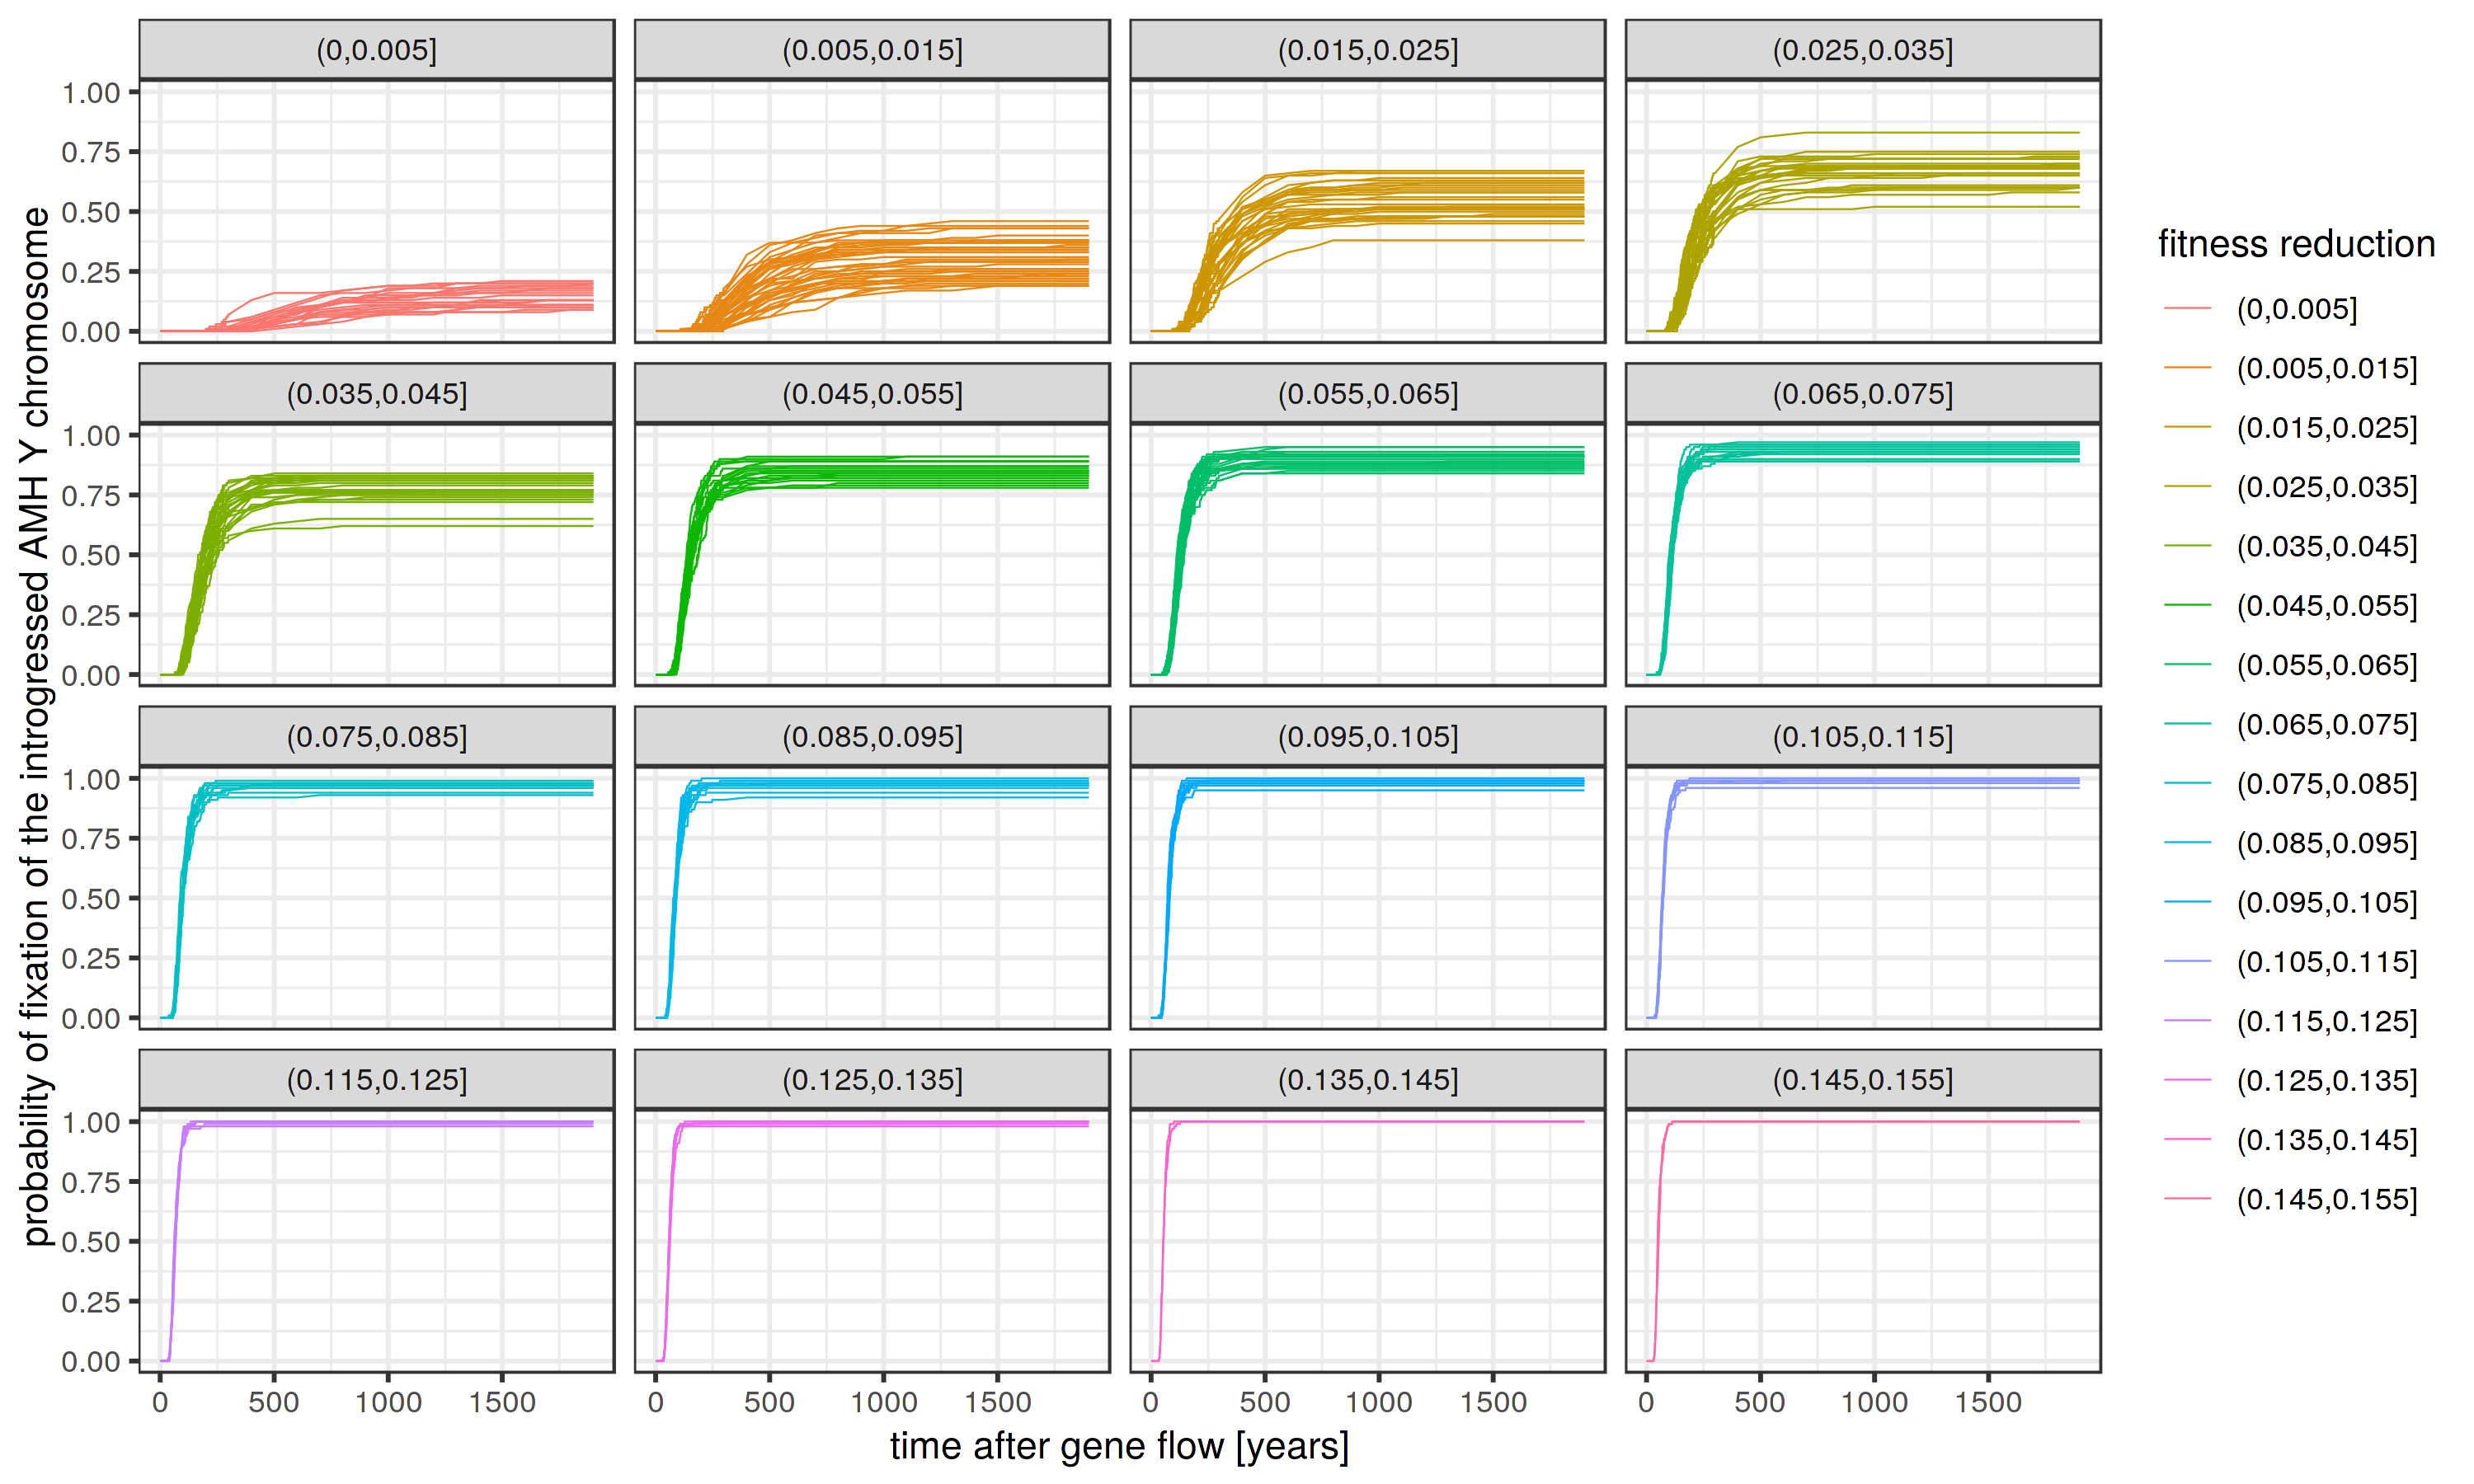

In [28]:
set_dim(10, 6)

prob_traj_fitness %>%
filter(gen < 2000) %>% 
ggplot(aes(gen, prob_fix, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time)), size = 1/5) +
    facet_wrap(~ fitness_bin) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of the introgressed AMH Y chromosome",
         x = "time after gene flow [years]")

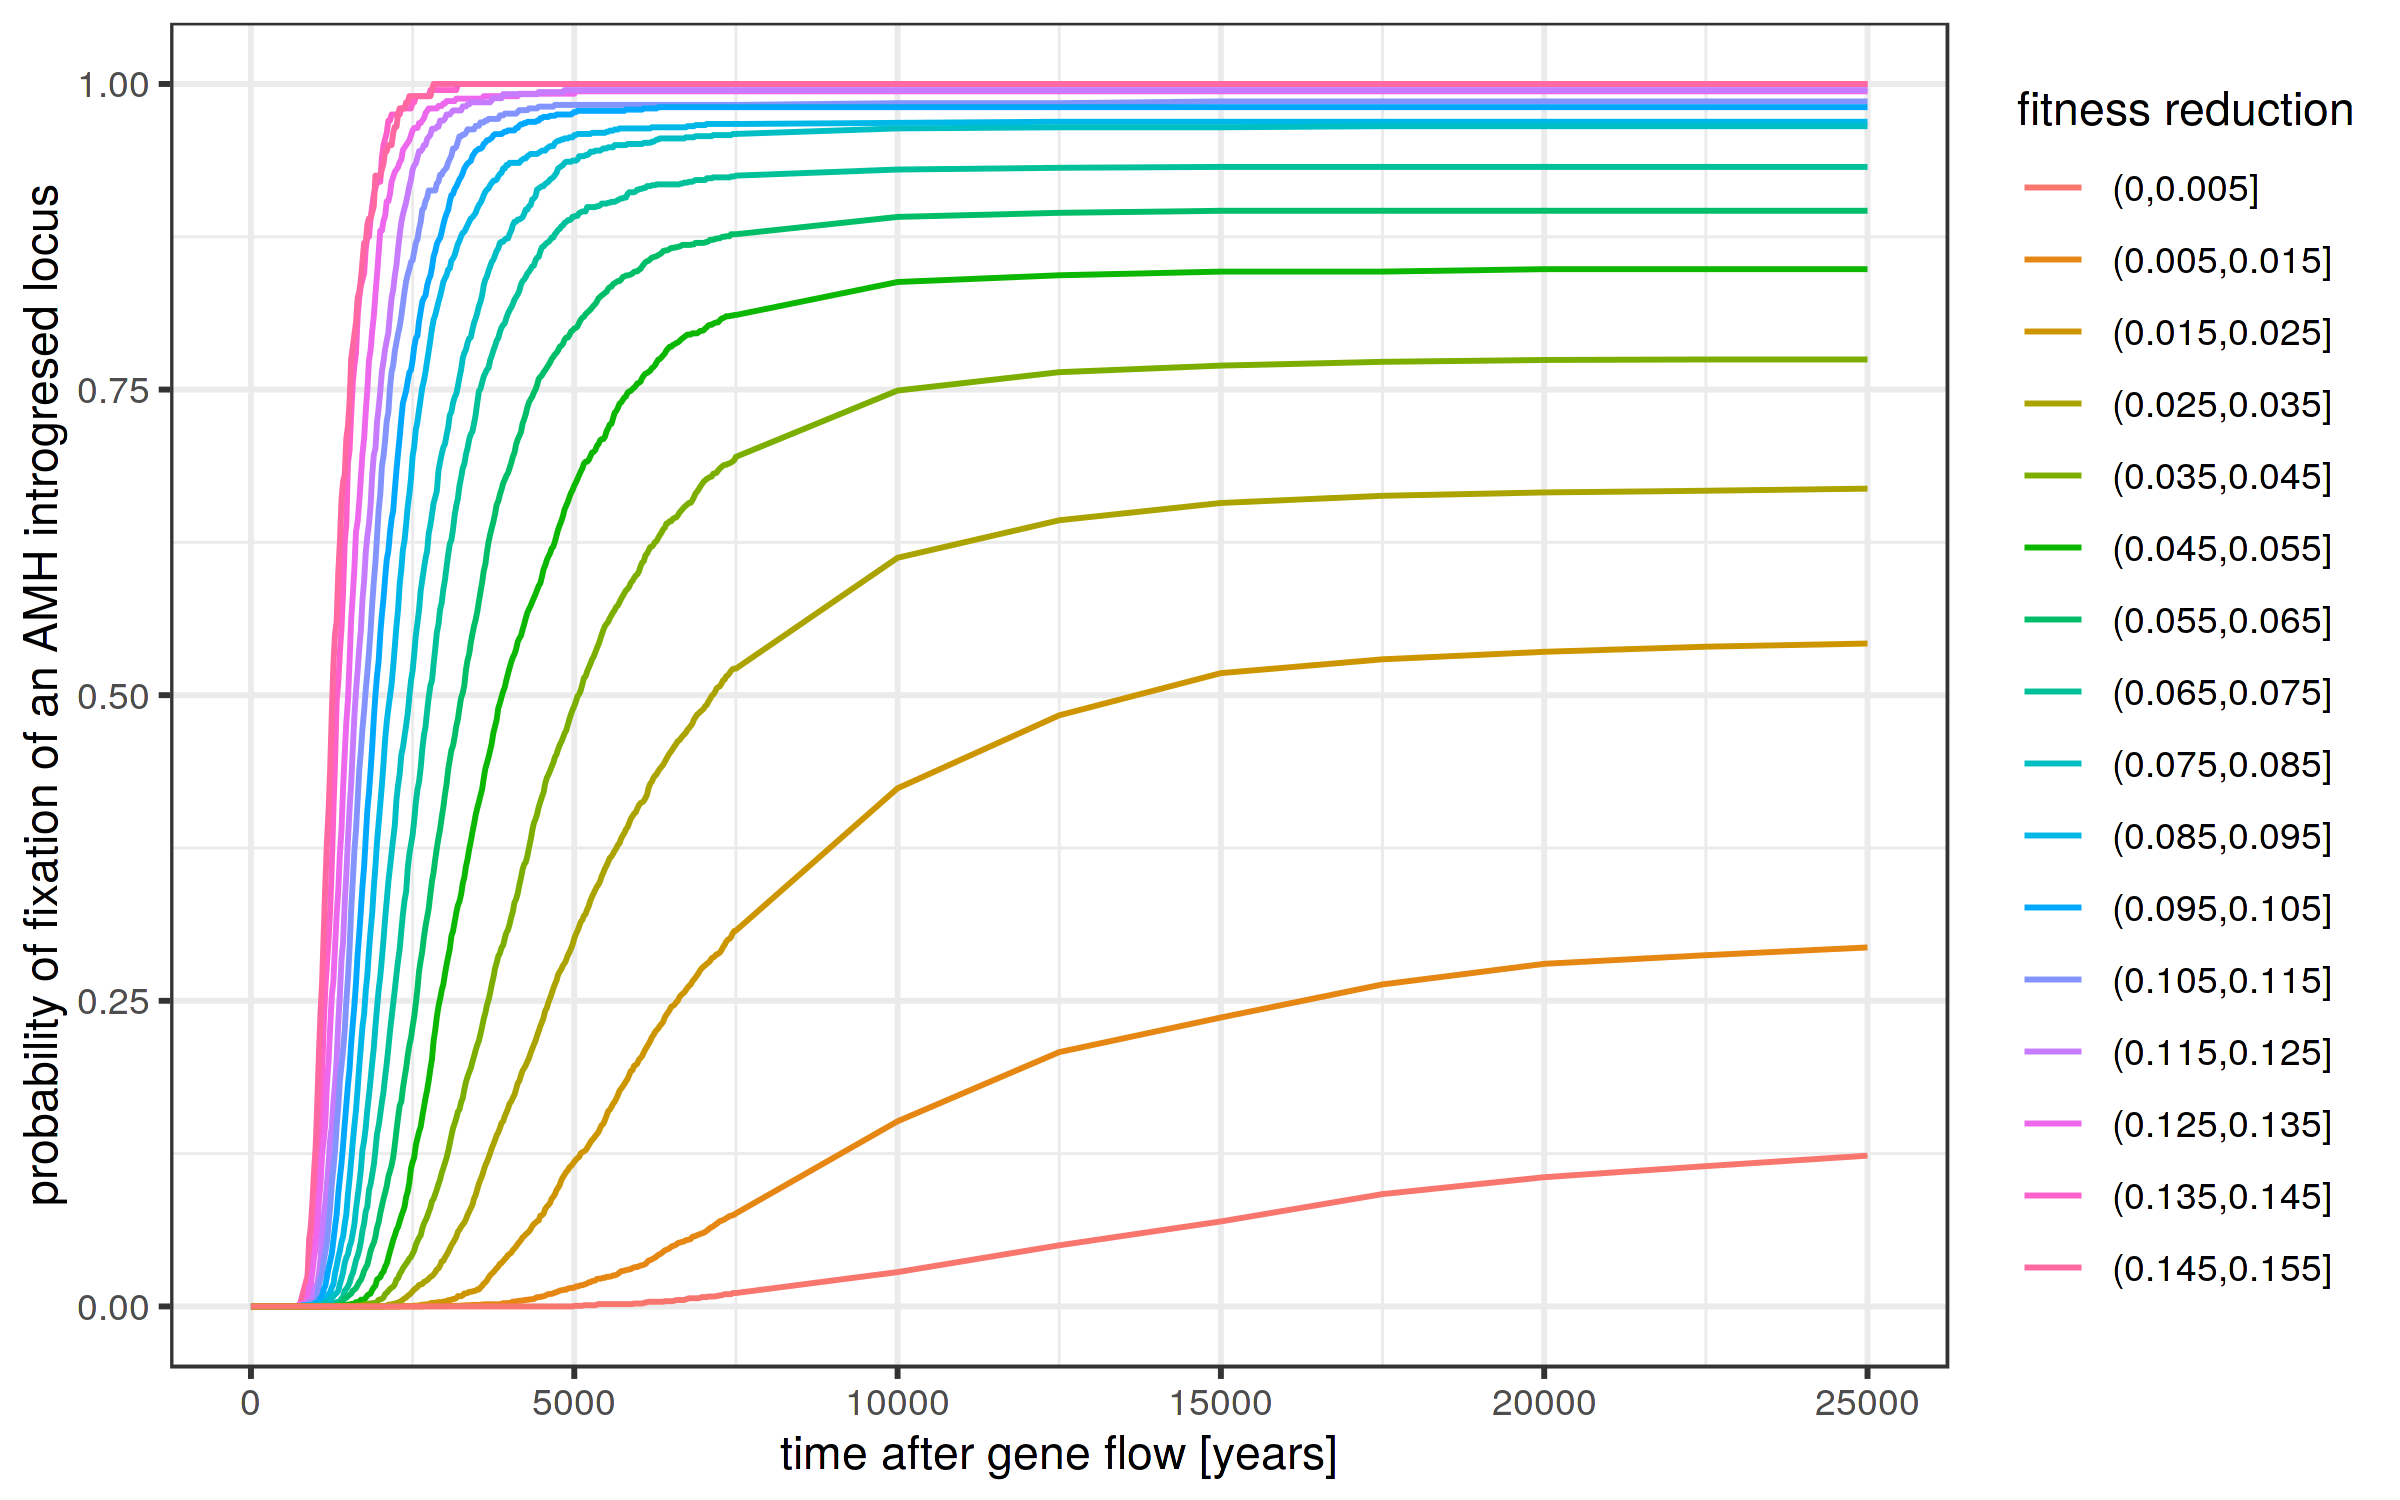

In [29]:
set_dim(8, 5)

prob_traj_fitness %>%
group_by(gen, time, fitness_bin) %>%
summarise_all(mean) %>%
filter(gen <= 1000) %>%
ggplot(aes(time, prob_fix, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of an AMH introgresed locus",
         x = "time after gene flow [years]")

## Plot theoretical predictions

In [30]:
P <- function(s, p = 0.05, Ne = 500) (1 - exp(-2*Ne*s*p) / (1 - exp(-2*Ne*s)))

In [31]:
prob_theory <- tibble(
    s = seq(0.01, 0.15, 0.01),
    fitness_bin = factor(glue("({s - 0.005},{s + 0.005}]")),
    time = "theory",
)

In [32]:
prob_theory

s    fitness_bin   time  
1  0.01 (0.005,0.015] theory
2  0.02 (0.015,0.025] theory
3  0.03 (0.025,0.035] theory
4  0.04 (0.035,0.045] theory
5  0.05 (0.045,0.055] theory
6  0.06 (0.055,0.065] theory
7  0.07 (0.065,0.075] theory
8  0.08 (0.075,0.085] theory
9  0.09 (0.085,0.095] theory
10 0.10 (0.095,0.105] theory
11 0.11 (0.105,0.115] theory
12 0.12 (0.115,0.125] theory
13 0.13 (0.125,0.135] theory
14 0.14 (0.135,0.145] theory
15 0.15 (0.145,0.155] theory

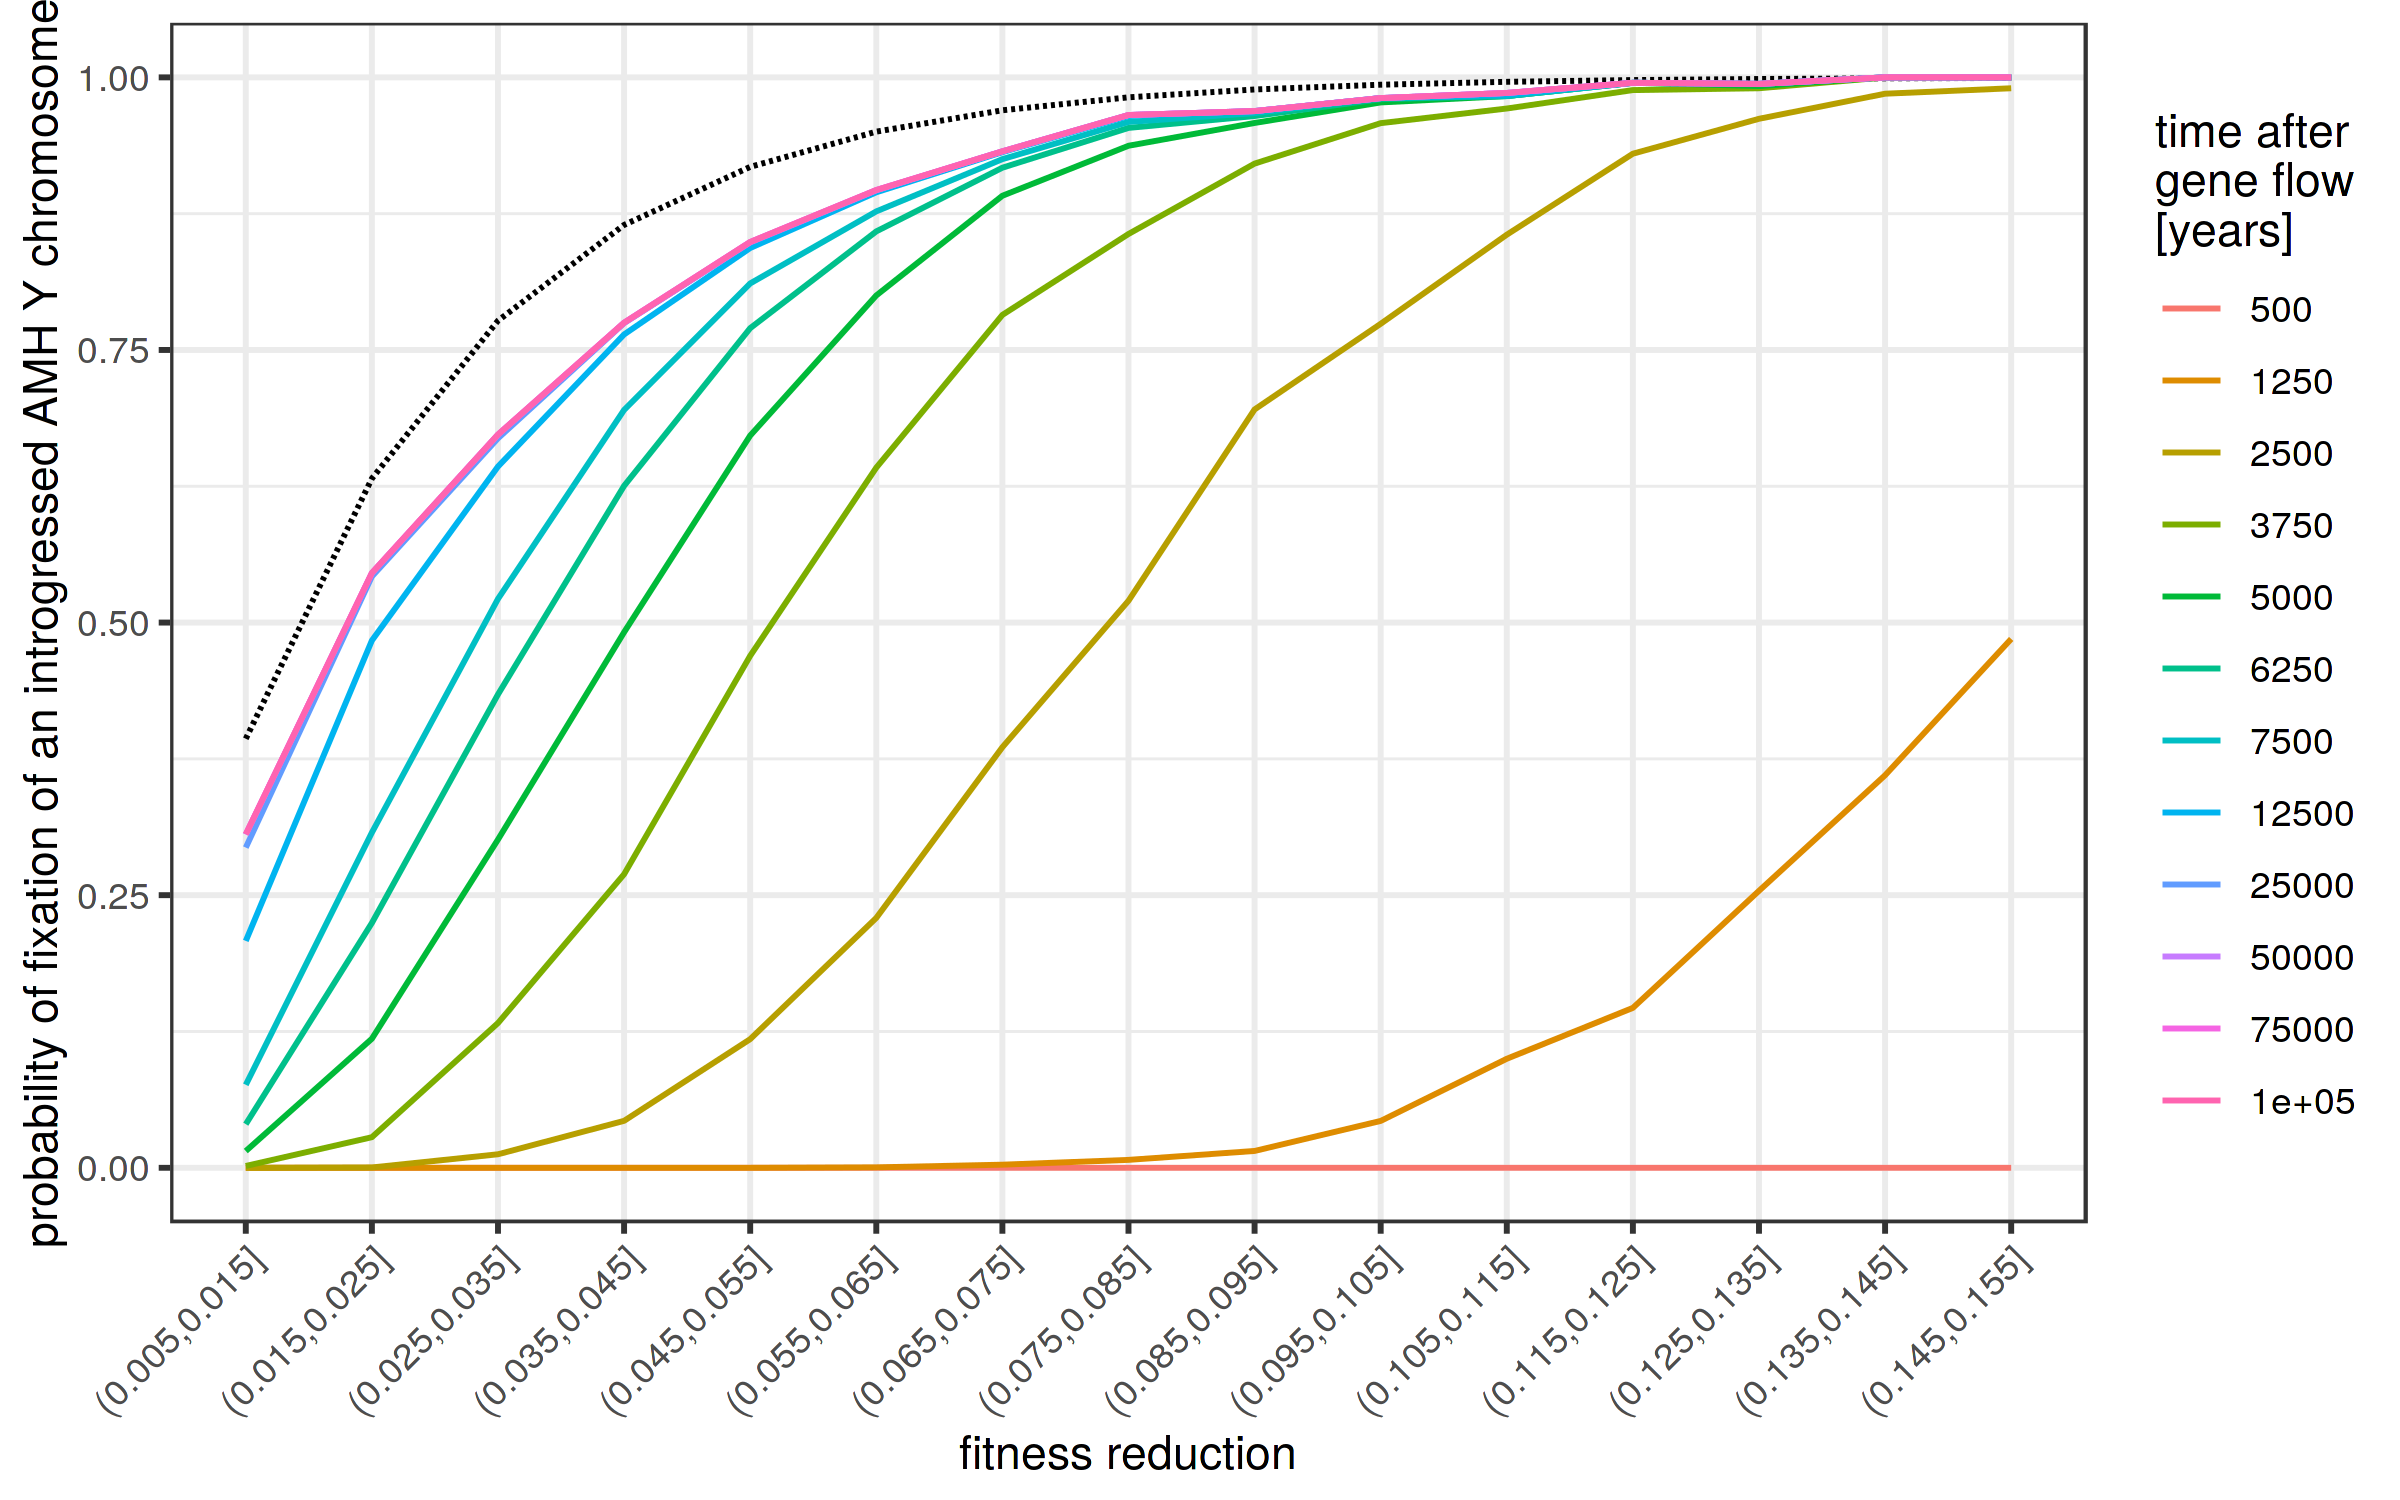

In [33]:
set_dim(8, 5)

prob_traj_fitness %>%
filter(fitness_bin != "(0,0.005]") %>% # filter out the lowest bin close to 0% fitness difference
group_by(gen, time, fitness_bin) %>%
summarise_all(mean) %>%
filter(gen %in% c(20, 50, 100, 150, 200, 250, 300, 500, 1000, 2000, 3000, 4000)) %>%
ggplot(aes(fitness_bin, prob_fix,
           color = factor(time),
           group = factor(time))) +
    geom_line(data = prob_theory, aes(fitness_bin, P(s, p = 0.05, Ne = 500)),
              color = "black", linetype = 2, size = 1/2) +
    geom_line() +
    ylim(0, 1) +
    theme_bw() +
    labs(x = "fitness reduction",
         y = "probability of fixation of an introgressed AMH Y chromosome",
         color = "time after\ngene flow\n[years]") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

## Decompose probabilities back on the 2D parameter grid

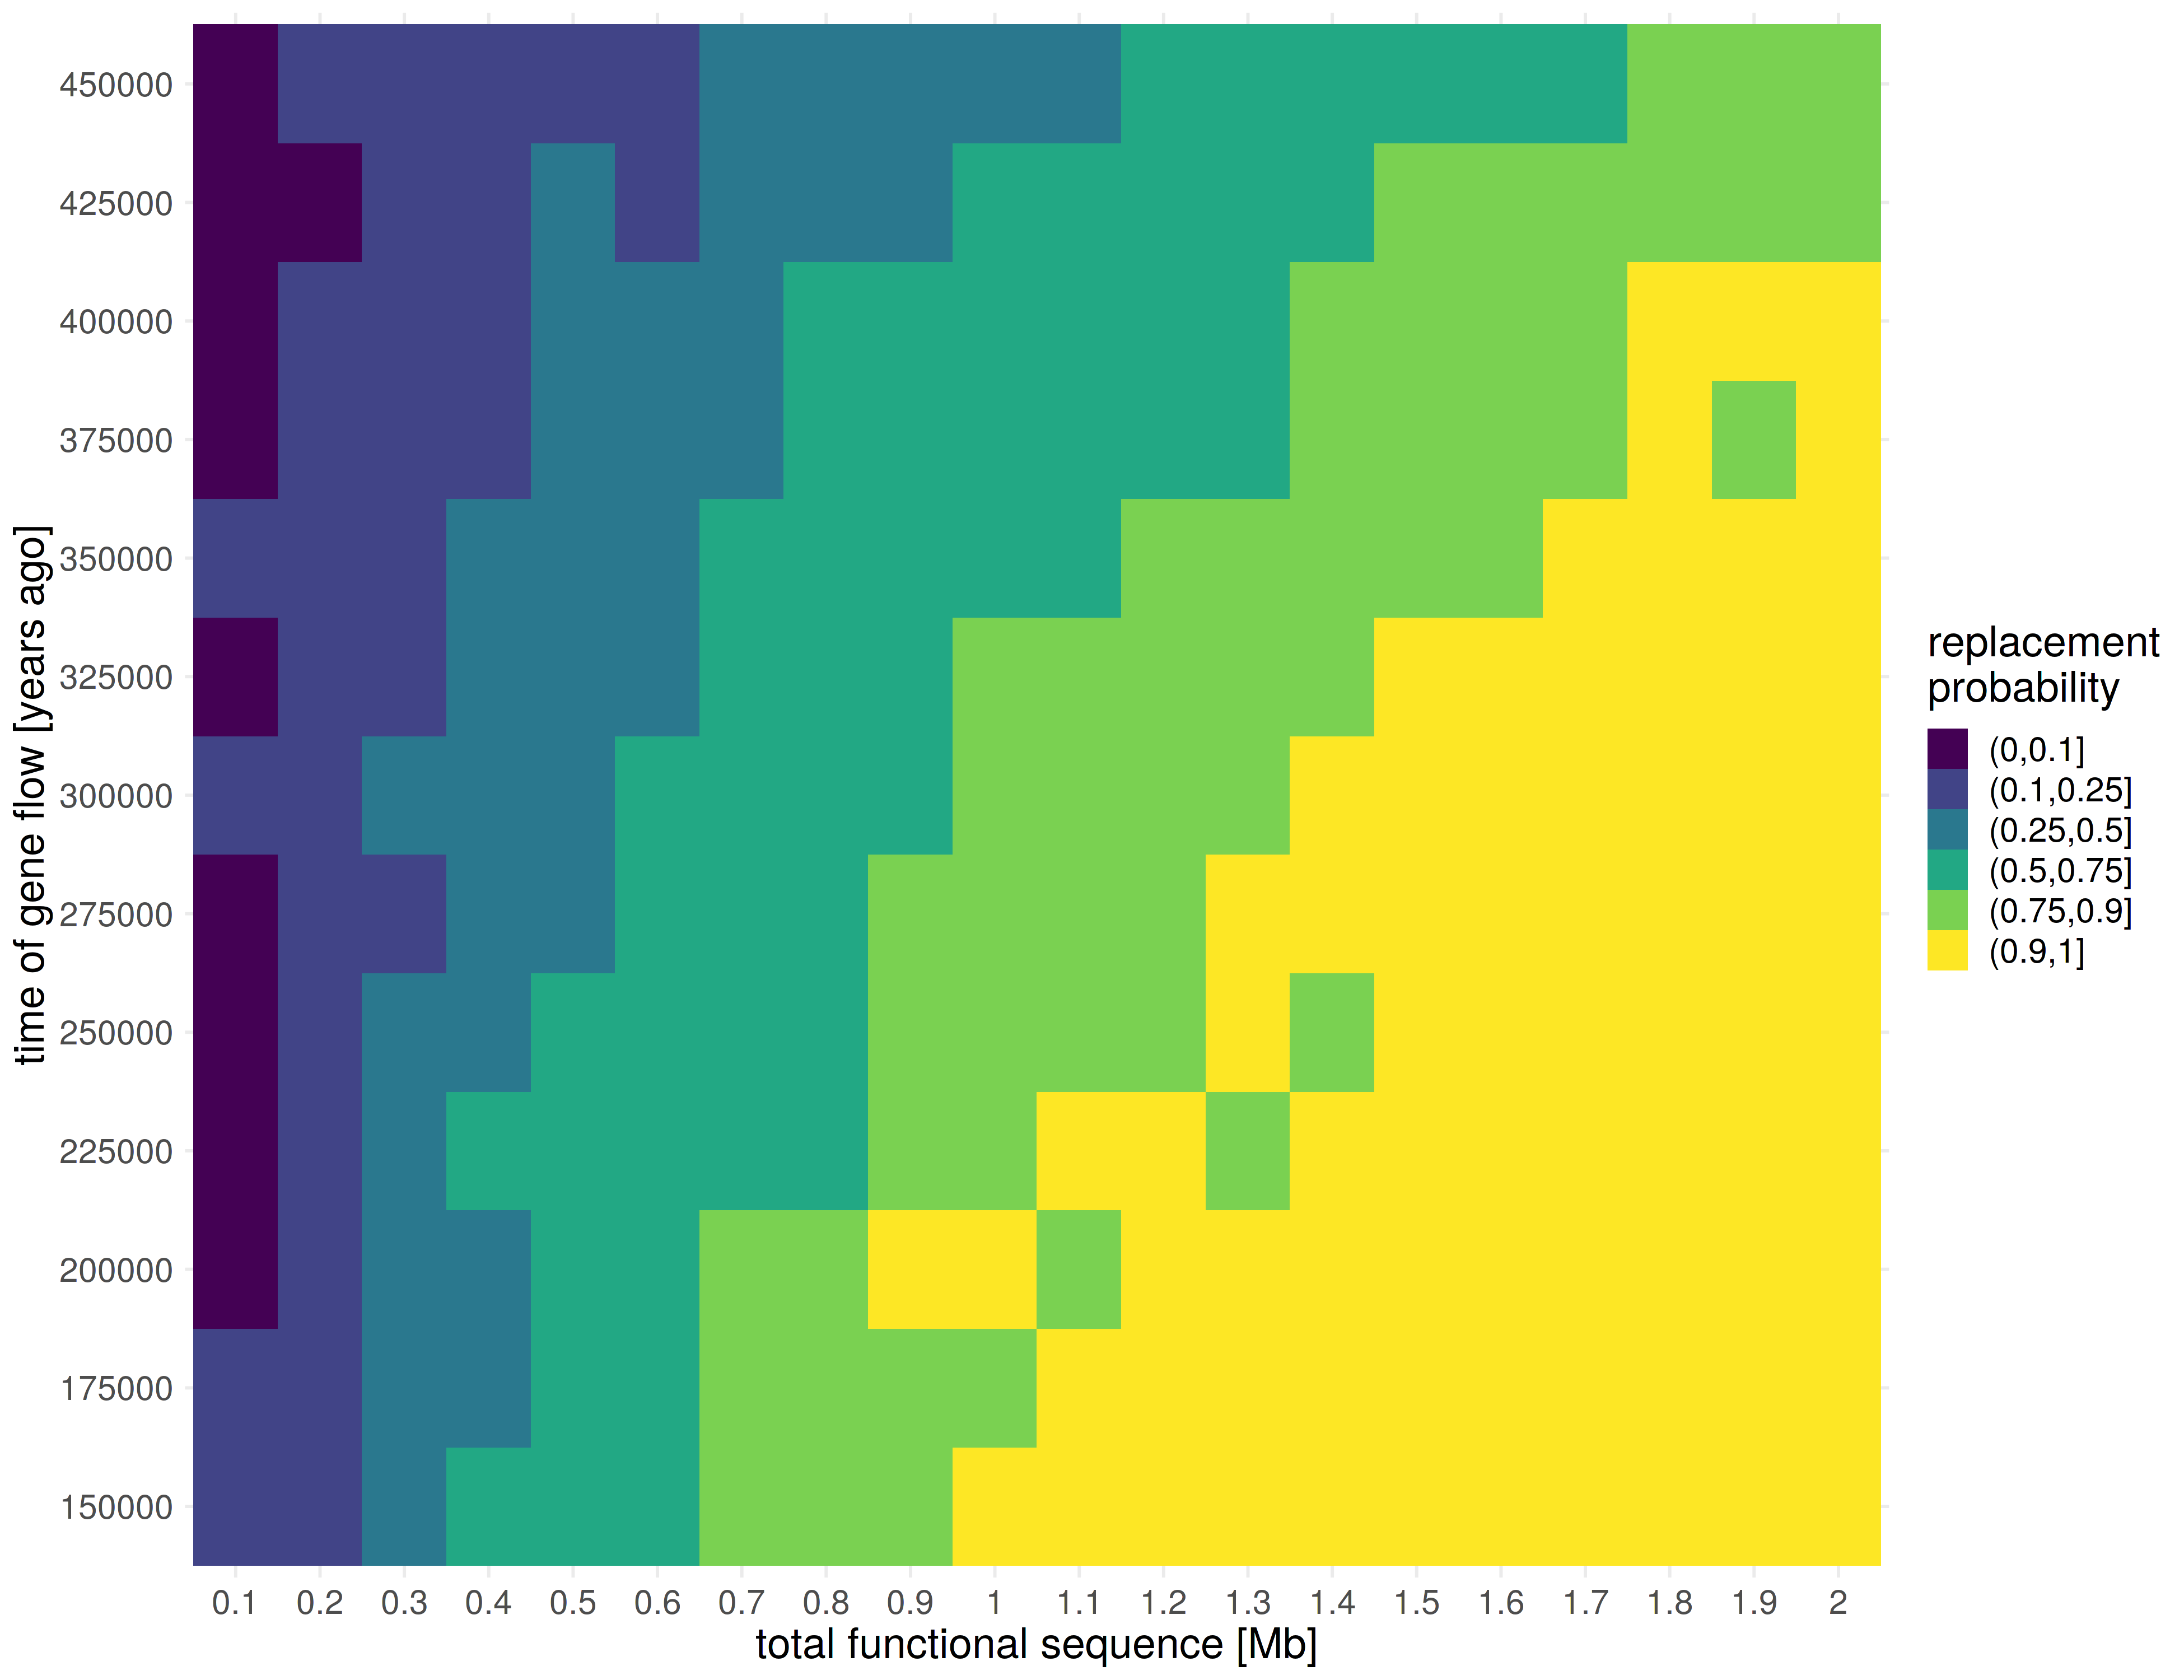

In [34]:
set_dim(13, 10)

prob_traj_fitness %>%
filter(time == 20000) %>%
ungroup %>%
mutate(
    prob_bin = cut(prob_fix, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1)),
    gene_total = gene_total / 1e6) %>% {
ggplot(data = ., aes(factor(gene_total), factor(admix_time))) +
    geom_tile(aes(fill = prob_bin)) +
    scale_fill_viridis_d() +
    guides(
        fill = guide_legend(title = "replacement\nprobability")
    ) +
    labs(y = "time of gene flow [years ago]", x = "total functional sequence [Mb]") +
    theme_minimal() +
    theme(text = element_text(size = 18))
}

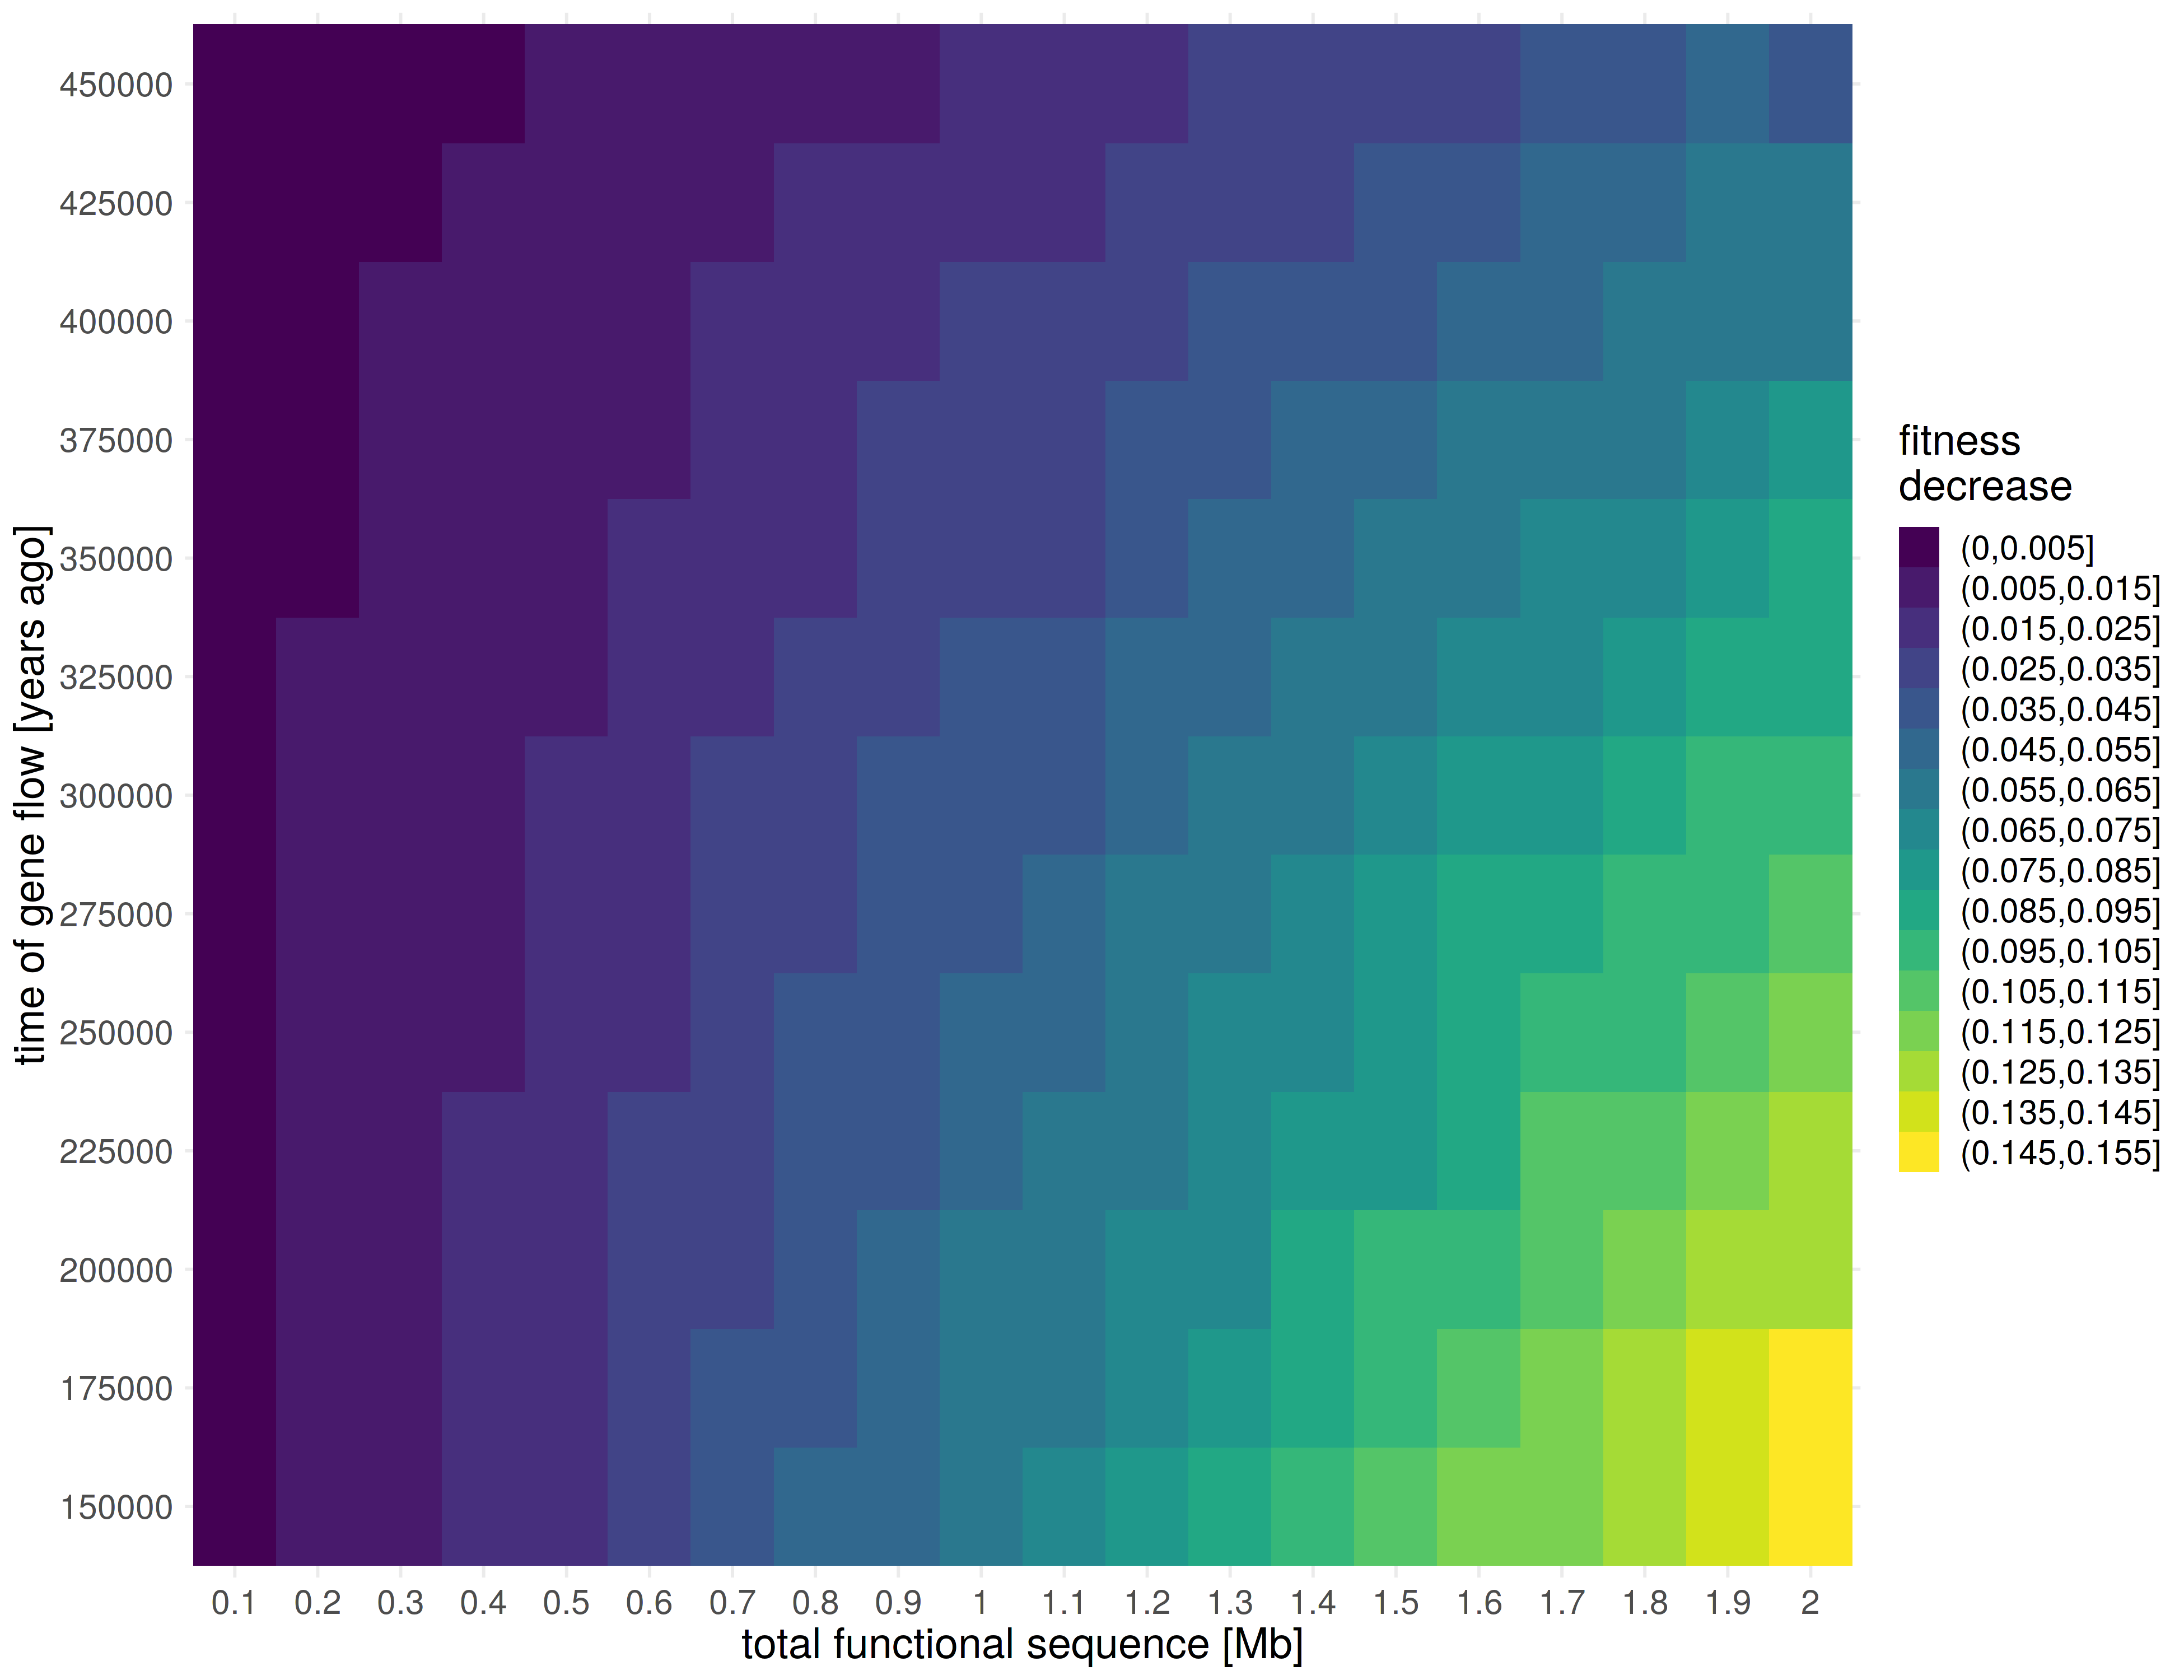

In [35]:
set_dim(13, 10)

prob_traj_fitness %>%
filter(time == 20000) %>%
ungroup %>%
mutate(
    prob_bin = cut(prob_fix, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1)),
    gene_total = gene_total / 1e6) %>% {
ggplot(data = ., aes(factor(gene_total), factor(admix_time))) +
    geom_tile(aes(fill = fitness_bin)) +
    scale_fill_viridis_d() +
    guides(
        fill = guide_legend(title = "fitness\ndecrease")
    ) +
    labs(y = "time of gene flow [years ago]", x = "total functional sequence [Mb]") +
    theme_minimal() +
    theme(text = element_text(size = 18))
}